In [1]:
%pip install numpy requests unidecode pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
# somarec_pipeline.py
# -*- coding: utf-8 -*-
import os, re, json, time, hashlib, pathlib, logging
from typing import List, Dict, Optional
import pandas as pd
import numpy as np
import requests
from unidecode import unidecode

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s"
)
log = logging.getLogger("somarec")

In [3]:
# -------------------- config --------------------
DATA = pathlib.Path("somarec_data")
RAW = DATA / "raw"
DERIVED = DATA / "derived"
CACHE = DATA / "cache"
for p in (RAW, DERIVED, CACHE): p.mkdir(parents=True, exist_ok=True)

USER_AGENT = "SomaRec/0.8 (nicole.nasengo@example.ke)"  # set to a reachable address
HEADERS_JSON = {"User-Agent": USER_AGENT, "Accept": "application/json"}

# Optional: load .env and keys
try:
    from dotenv import load_dotenv; load_dotenv()
except Exception:
    pass
# Use environment variable for Google Books API key
GB_KEY = os.getenv("GOOGLE_BOOKS_API_KEY")
if not GB_KEY:
    log.warning("Google Books API key not found in environment variables.")

In [4]:
# -------------------- utils --------------------
def norm_space(s: str) -> str:
    return re.sub(r"\s+", " ", (s or "").strip())

def norm_key(s: str) -> str:
    s = unidecode((s or "").lower())
    s = re.sub(r"[\.,'’`\"\-]+", " ", s)
    return re.sub(r"\s+", " ", s).strip()

def cache_read(key: str) -> Optional[dict]:
    p = CACHE / (hashlib.md5(key.encode()).hexdigest() + ".json")
    if p.exists():
        try: return json.loads(p.read_text())
        except Exception: return None
    return None

def cache_write(key: str, val: dict) -> None:
    p = CACHE / (hashlib.md5(key.encode()).hexdigest() + ".json")
    p.write_text(json.dumps(val, ensure_ascii=False), encoding="utf-8", errors="replace")

def safe_get(df: pd.DataFrame, col: str) -> pd.Series:
    return df[col] if col in df.columns else pd.Series([None]*len(df))


In [5]:

# -------------------- 1) data ingest --------------------
def load_kaggle_bookcrossing(
    bx_books_csv: Optional[str] = None,
    bx_ratings_csv: Optional[str] = None
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load Book-Crossing Books and Ratings. Provide explicit paths or place files under RAW.
    """
    # Prefer explicit paths; else try common names
    books_path = bx_books_csv or next((p for p in RAW.glob("**/BX-Books.csv")), None) \
                 or next((p for p in RAW.glob("**/Books.csv")), None)
    ratings_path = bx_ratings_csv or next((p for p in RAW.glob("**/BX-Book-Ratings.csv")), None)

    if not books_path:
        log.warning("Book-Crossing books file not found under somarec_data/raw.")
        books = pd.DataFrame()
    else:
        # BX is usually latin-1 with commas
        books = pd.read_csv(books_path, encoding="latin-1", on_bad_lines="skip")

    if ratings_path:
        ratings = pd.read_csv(ratings_path, encoding="latin-1", on_bad_lines="skip")
    else:
        ratings = pd.DataFrame()

    log.info(f"BX Books shape: {books.shape}; Ratings shape: {ratings.shape}")
    return books, ratings


In [6]:

# -------------------- 2) wikidata authors + works --------------------
WD_ENDPOINT = "https://query.wikidata.org/sparql"

def wd_sparql(q: str) -> dict:
    r = requests.get(
        WD_ENDPOINT,
        params={"query": q, "format": "json"},
        headers={"User-Agent": USER_AGENT, "Accept": "application/sparql-results+json"},
        timeout=60
    )
    r.raise_for_status()
    time.sleep(0.5)  # be nice to WDQS
    return r.json()

SPARQL_AUTHORS_KE = r"""
SELECT DISTINCT ?author ?authorLabel (GROUP_CONCAT(DISTINCT ?alias; separator="\n") AS ?aliases)
WHERE {
  ?author wdt:P31 wd:Q5 .
  ?author wdt:P27 wd:Q114 .    # human, Kenyan citizenship
  ?author wdt:P106 ?occ .
  VALUES ?occ { wd:Q36180 wd:Q49757 wd:Q482980 wd:Q214917 wd:Q6625963 wd:Q18844224 wd:Q117291434 }
  OPTIONAL { ?author skos:altLabel ?alias FILTER (LANG(?alias)="en") }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en,sw,en-gb". }
}
GROUP BY ?author ?authorLabel
ORDER BY ?authorLabel
"""

SPARQL_WORKS_KE = r"""
SELECT DISTINCT ?work ?workLabel ?authorLabel ?pubdate ?langLabel ?publisherLabel ?isbn13 ?isbn10 ?ol
WHERE {
  ?author wdt:P31 wd:Q5 ; wdt:P27 wd:Q114 .
  ?work wdt:P50 ?author .
  VALUES ?litclass {
    wd:Q47461344  # written work
    wd:Q8261      # novel
    wd:Q7725634   # literary work
    wd:Q25379     # play
    wd:Q7726210   # short story
    wd:Q49848     # poem
  }
  ?work wdt:P31 ?litclass .
  OPTIONAL { ?work wdt:P577 ?pubdate. }
  OPTIONAL { ?work wdt:P407 ?lang. }
  OPTIONAL { ?work wdt:P123 ?publisher. }
  OPTIONAL { ?work wdt:P212 ?isbn13. }
  OPTIONAL { ?work wdt:P957 ?isbn10. }
  OPTIONAL { ?work wdt:P648 ?ol. }  # Open Library work id
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en,sw,en-gb". }
}
"""

def get_kenyan_authors() -> pd.DataFrame:
    js = wd_sparql(SPARQL_AUTHORS_KE)
    rows = js["results"]["bindings"]
    out = []
    for r in rows:
        name = r["authorLabel"]["value"].strip()
        aliases = (r.get("aliases", {}).get("value") or "")
        alias_set = sorted(set([a.strip() for a in aliases.split("\n") if a.strip()] + [name]))
        out.append({"name": name, "aliases": "\n".join(alias_set)})
    df = pd.DataFrame(out).sort_values("name").reset_index(drop=True)
    df.to_csv(DERIVED / "kenyan_authors.csv", index=False)
    log.info(f"Kenyan authors: {df.shape}")
    return df

def get_wikidata_works() -> pd.DataFrame:
    js = wd_sparql(SPARQL_WORKS_KE)
    rows = js["results"]["bindings"]
    def v(r, k): return r.get(k, {}).get("value")
    wk = [{
        "wd_work": v(r,"work"),
        "title": v(r,"workLabel"),
        "author": v(r,"authorLabel"),
        "pubdate": v(r,"pubdate"),
        "language": v(r,"langLabel"),
        "publisher": v(r,"publisherLabel"),
        "isbn13": v(r,"isbn13"),
        "isbn10": v(r,"isbn10"),
        "ol_work_id": v(r,"ol"),
        "source": "wikidata"
    } for r in rows]
    df = pd.DataFrame(wk).drop_duplicates()
    log.info(f"Wikidata works: {df.shape}")
    return df


In [7]:
# -------------------- 3) open library harvest --------------------
OL_SEARCH = "https://openlibrary.org/search.json"

def ol_search(params: dict, delay: float = 0.25) -> dict:
    key = "ol::" + json.dumps(params, sort_keys=True)
    hit = cache_read(key)
    if hit: return hit
    r = requests.get(OL_SEARCH, params=params, headers=HEADERS_JSON, timeout=45)
    r.raise_for_status()
    js = r.json()
    cache_write(key, js)
    time.sleep(delay)
    return js

KE_PUBLISHERS = [
    "East African Educational Publishers",
    "Kenya Literature Bureau",
    "Longhorn Publishers",
    "Jomo Kenyatta Foundation",
]

def build_alias_set(authors_df: pd.DataFrame) -> set[str]:
    aliases = set()
    for s in authors_df["aliases"]:
        for a in str(s).split("\n"):
            a = a.strip()
            if a:
                aliases.add(a)
    return { norm_key(a) for a in aliases }

def ol_collect_docs(seed_authors: list[str]) -> pd.DataFrame:
    docs = []
    # (1) author
    for a in seed_authors:
        js = ol_search({"author": a, "limit": 20})
        for d in js.get("docs", []):
            d["_source"] = "ol_author"; d["_author_q"] = a
            docs.append(d)
    # (2) publisher
    for pub in KE_PUBLISHERS:
        js = ol_search({"q": f'publisher:"{pub}"', "limit": 50})
        for d in js.get("docs", []):
            d["_source"] = "ol_publisher"; d["_publisher_q"] = pub
            docs.append(d)
    # (3) subject slice – Kenya, fiction
    try:
        sj = requests.get(
            "https://openlibrary.org/subjects/kenya_fiction.json?details=false&limit=200",
            headers=HEADERS_JSON, timeout=45
        ).json()
        time.sleep(0.25)
        for w in sj.get("works", []):
            docs.append({
                "title": w.get("title"),
                "author_name": [a.get("name") for a in (w.get("authors") or []) if a],
                "key": w.get("key"),
                "edition_count": w.get("edition_count"),
                "cover_i": (w.get("cover_id") or None),
                "_source": "ol_subject_kenya_fiction"
            })
    except Exception as e:
        log.warning(f"Open Library subject fetch failed: {e}")

    # Fetch descriptions for each doc using the Open Library API (details=true) if missing
    for doc in docs:
        if doc.get('key') and not doc.get('description'):
            try:
                details_url = f"https://openlibrary.org{doc['key']}.json"
                # Check cache first
                details_key = "ol_details::" + doc['key']
                details_js = cache_read(details_key)
                if not details_js:
                    details_r = requests.get(details_url, headers=HEADERS_JSON, timeout=45)
                    details_r.raise_for_status()
                    details_js = details_r.json()
                    cache_write(details_key, details_js)
                    time.sleep(0.25) # Be nice to OL

                desc = details_js.get('description')
                if desc:
                    # Description can be a string or a dict with a value key
                    if isinstance(desc, dict) and 'value' in desc:
                        doc['description'] = desc['value']
                    elif isinstance(desc, str):
                        doc['description'] = desc
            except Exception as e:
                log.warning(f"Failed to fetch OL description for {doc.get('key')}: {e}")

    return pd.DataFrame(docs)

In [8]:
# -------------------- 4) harmonize + dedupe --------------------
def map_to_canonical(df: pd.DataFrame) -> pd.DataFrame:
    """Map mixed columns to a consistent schema."""
    out = pd.DataFrame({
        "title": df.get("title", df.get("Book-Title")),
        "author": df.get("author", df.get("Book-Author")),
        "publisher": df.get("publisher"),
        "isbn10": df.get("isbn10", df.get("ISBN", None)),
        "isbn13": df.get("isbn13"),
        "language": df.get("language"),
        "pubdate": df.get("pubdate"),
        "ol_work_key": df.get("ol_work_id", df.get("key")),
        "cover_i": df.get("cover_i"),
        "image_url": df.get("image_url"),  # to be filled later
        "source": df.get("source"),
        "description": df.get("description") # Include description
    })
    return out

def dedupe_union(base: pd.DataFrame, add: pd.DataFrame) -> pd.DataFrame:
    base = map_to_canonical(base)
    add  = map_to_canonical(add)
    # Dedup key: prefer ISBN13 > ISBN10 > (title+author)
    base["key_isbn"] = base["isbn13"].fillna(base["isbn10"])
    add["key_isbn"]  = add["isbn13"].fillna(add["isbn10"])
    base["key_ta"]   = (base["title"].map(norm_key) + " | " + base["author"].map(norm_key))
    add["key_ta"]    = (add["title"].map(norm_key)  + " | "  + add["author"].map(norm_key))
    have = set(base["key_isbn"].dropna()) | set(base["key_ta"].dropna())
    is_new = ~(
        add["key_isbn"].isin(have) |
        add["key_ta"].isin(have)
    )
    # Drop columns that are all NA in either dataframe before concatenating,
    # but explicitly keep 'image_url' and 'description'
    cols_to_drop_base = set(base.columns[base.isnull().all()]) - {'image_url', 'description'}
    cols_to_drop_add = set(add.columns[add.isnull().all()]) - {'image_url', 'description'}

    merged = pd.concat([base.drop(columns=cols_to_drop_base, errors='ignore'),
                        add[is_new].drop(columns=cols_to_drop_add, errors='ignore')],
                       ignore_index=True)


    # Ensure key columns exist before dropping duplicates
    subset_cols = []
    if "key_isbn" in merged.columns:
        subset_cols.append("key_isbn")
    if "key_ta" in merged.columns:
        subset_cols.append("key_ta")

    if subset_cols:
        return merged.drop_duplicates(subset=subset_cols, keep="first")
    else:
        # If no key columns exist, return the merged dataframe as is (no deduplication)
        return merged

In [9]:
# -------------------- 5) Google Books enrichment (optional) --------------------
GB_BASE = "https://www.googleapis.com/books/v1"

def gb_search(q: str, max_results: int = 40, lang: Optional[str] = None) -> dict:
    params = {"q": q, "maxResults": min(max_results, 40)}
    if GB_KEY: params["key"] = GB_KEY
    if lang: params["langRestrict"] = lang
    key = "gb::" + json.dumps(params, sort_keys=True)
    hit = cache_read(key)
    if hit: return hit
    r = requests.get(f"{GB_BASE}/volumes", params=params,
                     headers={"User-Agent": USER_AGENT}, timeout=45)
    r.raise_for_status()
    js = r.json()
    cache_write(key, js)
    time.sleep(0.25)
    return js

def gb_flatten_item(item: dict, source: str) -> dict:
    v = item.get("volumeInfo", {}) or {}
    def extract_isbns():
        vals = []
        for ii in (v.get("industryIdentifiers") or []):
            ident = ii.get("identifier")
            if ident:
                vals.append(re.sub(r"[^\dxX]", "", ident))
        # Return both formats where possible
        isbn10 = next((x for x in vals if len(x) == 10), None)
        isbn13 = next((x for x in vals if len(x) == 13), None)
        return isbn10, isbn13
    i10, i13 = extract_isbns()
    return {
        "_src": source,
        "gb_id": item.get("id"),
        "title": v.get("title"),
        "authors": "\n".join(v.get("authors") or []),
        "publisher": v.get("publisher"),
        "publishedDate": v.get("publishedDate"),
        "categories": "\n".join(v.get("categories") or []),
        "avg_rating": v.get("averageRating"),
        "ratings_count": v.get("ratingsCount"),
        "thumbnail": (v.get("imageLinks") or {}).get("thumbnail"),
        "infoLink": v.get("infoLink"),
        "isbn10": i10, "isbn13": i13,
        "language": v.get("language"),
        "description": v.get("description") # Add description field
    }

In [10]:
# -------------------- 6) main orchestrator --------------------
def run_pipeline():
    bx_books, bx_ratings = load_kaggle_bookcrossing()

    # Wikidata authors & works
    authors_df = get_kenyan_authors()
    wd_works   = get_wikidata_works()

    # Build exact + alias matches for Kaggle base (Book-Crossing books)
    alias_norm = {norm_key(a) for a in authors_df["aliases"].str.split("\n").sum()}
    def is_kenyan_author(name: str) -> bool:
        return norm_key(name) in alias_norm if isinstance(name, str) else False

    bx_books_kenya = pd.DataFrame()
    if not bx_books.empty:
        auth_col = next((c for c in bx_books.columns if norm_key(c) in ("book author","author","authors")), None)
        if auth_col:
            bx_books_kenya = bx_books[bx_books[auth_col].apply(is_kenyan_author)].copy()
            bx_books_kenya["source"] = "kaggle_bx"


    # Open Library harvest
    seed_authors = sorted({ norm_space(a) for a in authors_df["name"].tolist() })
    ol_docs = ol_collect_docs(seed_authors)

    # Normalize OL docs → canonical rows
    rows = []
    for _, d in ol_docs.iterrows():
        title = d.get("title") or d.get("title_suggest")
        authors = d.get("author_name") or []
        if not title or not authors: continue
        # Add a check here to ensure authors is a list before iterating
        if not isinstance(authors, list) or not any(norm_key(a) in alias_norm for a in authors): continue

        # Description is now fetched within ol_collect_docs
        description = d.get("description")


        rows.append({
            "title": title,
            "author": authors[0],
            "publisher": "\n".join((d.get("publisher") or [])[:5]) if d.get("publisher") else None,
            "isbn13": None, "isbn10": None,
            "language": None,
            "pubdate": d.get("first_publish_year"),
            "ol_work_key": d.get("key"),
            "cover_i": d.get("cover_i"),
            "image_url": f"https://covers.openlibrary.org/b/id/{d.get('cover_i')}-L.jpg" if d.get('cover_i') else None,
            "source": d.get("_source"),
            "description": description # Include description

        })
    ol_finds = pd.DataFrame(rows).drop_duplicates()

    # Union: Kaggle (Kenyan subset) + Wikidata works + OL finds
    base = pd.concat([bx_books_kenya, wd_works], ignore_index=True, sort=False)
    augmented = dedupe_union(base, ol_finds)

    # Explicitly ensure 'description' and 'image_url' columns exist before enrichment
    # This should ideally be handled by dedupe_union now, but keeping as a failsafe
    if 'description' not in augmented.columns:
        augmented['description'] = None
    if 'image_url' not in augmented.columns:
        augmented['image_url'] = None

    # Debugging: Print columns before Google Books enrichment
    log.info(f"Columns in augmented DataFrame before Google Books enrichment: {augmented.columns.tolist()}")


    # (Optional) Google Books enrichment for missing descriptions and images
    if GB_KEY:
        log.info("Enriching with Google Books...")

        def enrich_with_gb(row):
            # Use .get for safe access to original values
            original_description = row.get('description')
            original_image_url = row.get('image_url')

            needs_enrichment = pd.isna(original_description) or pd.isna(original_image_url)

            if needs_enrichment:
                query = f"{row.get('title', '')} {row.get('author', '')}" # Use .get for safe access
                try:
                    search_results = gb_search(query, max_results=1)
                    if search_results and search_results.get('items'):
                        flat_item = gb_flatten_item(search_results['items'][0], "google_books_enrichment")
                        # Update row values if enrichment found data and original is missing
                        if flat_item.get('description') and pd.isna(original_description):
                            row['description'] = flat_item['description']
                        if flat_item.get('thumbnail') and pd.isna(original_image_url):
                            row['image_url'] = flat_item['thumbnail']
                except Exception as e:
                    log.warning(f"Google Books search failed for '{query}': {e}")
                    # Continue with original row if search fails

            return row # Return the potentially updated row

        # Apply the enrichment function row-wise
        # Use augmented.index to preserve the original index after apply
        augmented = augmented.apply(enrich_with_gb, axis=1)


    # Image URL preference: OL cover if present and no image_url from GB
    # This part was already handled during OL and GB enrichment, but keep as a final check
    # Apply image_url logic after potential GB enrichment
    def image_url(row):
        # Use .get for safe access
        if pd.notnull(row.get("image_url")):
            return row["image_url"]
        elif pd.notnull(row.get("cover_i")):
            try: return f"https://covers.openlibrary.org/b/id/{int(row['cover_i'])}-L.jpg"
            except Exception: return None
        return None
    # Only apply if image_url column exists
    if 'image_url' in augmented.columns:
        augmented["image_url"] = augmented.apply(image_url, axis=1)


    out_path = DERIVED / "kenyan_works_augmented.csv"
    augmented.to_csv(out_path, index=False, encoding="utf-8", errors="replace")
    log.info(f"Wrote {out_path} with {augmented.shape[0]} rows.")

    # (Optional) keep ratings for future recommender
    if not bx_ratings.empty:
        bx_ratings.to_csv(DERIVED / "bx_ratings.csv", index=False, encoding="utf-8", errors="replace")


if __name__ == "__main__":
    run_pipeline()

2025-10-26 16:16:17,280 WARNING Book-Crossing books file not found under somarec_data/raw.
2025-10-26 16:16:17,289 INFO BX Books shape: (0, 0); Ratings shape: (0, 0)
2025-10-26 16:16:20,723 INFO Kenyan authors: (119, 2)
2025-10-26 16:16:25,065 INFO Wikidata works: (115, 10)
2025-10-26 16:20:34,877 INFO Columns in augmented DataFrame before Google Books enrichment: ['title', 'author', 'publisher', 'isbn10', 'isbn13', 'language', 'pubdate', 'ol_work_key', 'image_url', 'source', 'description', 'key_isbn', 'key_ta', 'cover_i']
2025-10-26 16:20:34,879 INFO Enriching with Google Books...
2025-10-26 16:30:38,677 INFO Wrote somarec_data\derived\kenyan_works_augmented.csv with 451 rows.


In [11]:
# Save the updated DataFrame (even with the Google Books enrichment error)
out_path = DERIVED / "kenyan_works_augmented.csv"
if 'augmented' in globals() and isinstance(augmented, pd.DataFrame):
    augmented.to_csv(out_path, index=False, encoding="utf-8", errors="replace")
    log.info(f"Saved current state of data to {out_path}.")
else:
    log.error("DataFrame 'augmented' not found. Cannot save.")

2025-10-26 16:30:38,698 ERROR DataFrame 'augmented' not found. Cannot save.


In [12]:
import pandas as pd

# Reload the DataFrame
out_path = DERIVED / "kenyan_works_augmented.csv"
try:
    augmented_works_df = pd.read_csv(out_path)
    log.info(f"Reloaded data from {out_path}. Shape: {augmented_works_df.shape}")
    display(augmented_works_df.head())
except FileNotFoundError:
    log.error(f"Error: File not found at {out_path}. Please ensure the pipeline ran successfully at least once.")
    augmented_works_df = pd.DataFrame() # Create an empty DataFrame to avoid further errors

2025-10-26 16:30:38,762 INFO Reloaded data from somarec_data\derived\kenyan_works_augmented.csv. Shape: (451, 14)


,title,author,publisher,isbn10,isbn13,language,pubdate,ol_work_key,image_url,source,description,key_isbn,key_ta,cover_i
0,Homecoming,Ngũgĩ wa Thiong'o,Amazon Kindle,NaN,NaN,English,2023-10-01T00:00:00Z,NaN,http://books.google.com/books/content?id=CHroE...,wikidata,In this collection of essays on African and Ca...,NaN,homecoming | ngugi wa thiong o,NaN
1,Black Star Nairobi,Mũkoma wa Ngũgĩ,NaN,NaN,NaN,English,2013-01-01T00:00:00Z,NaN,http://books.google.com/books/content?id=NBHK8...,wikidata,"Two cops—one American, one Kenyan—team up to t...",NaN,black star nairobi | mukoma wa ngugi,NaN
2,Dreams from My Father,Barack Obama,NaN,NaN,NaN,English,1995-07-18T00:00:00Z,OL3246385W,http://books.google.com/books/content?id=yya9I...,wikidata,The son of a black African father and a white ...,NaN,dreams from my father | barack obama,NaN
3,Spartacus: The Gladiator,Ben Kane,NaN,NaN,NaN,English,2014-01-01T00:00:00Z,NaN,http://books.google.com/books/content?id=MnmME...,wikidata,The first of two epic novels which tell the st...,NaN,spartacus: the gladiator | ben kane,NaN
4,The Trial of Dedan Kimathi,Micere Githae Mugo,NaN,0-435-90191-5,978-0-435-90191-2,English,1977-01-01T00:00:00Z,NaN,NaN,wikidata,NaN,978-0-435-90191-2,the trial of dedan kimathi | micere githae mugo,NaN


In [13]:
import pandas as pd

augmented_works_df = pd.read_csv('somarec_data/derived/kenyan_works_augmented.csv')
display(augmented_works_df.head())

,title,author,publisher,isbn10,isbn13,language,pubdate,ol_work_key,image_url,source,description,key_isbn,key_ta,cover_i
0,Homecoming,Ngũgĩ wa Thiong'o,Amazon Kindle,NaN,NaN,English,2023-10-01T00:00:00Z,NaN,http://books.google.com/books/content?id=CHroE...,wikidata,In this collection of essays on African and Ca...,NaN,homecoming | ngugi wa thiong o,NaN
1,Black Star Nairobi,Mũkoma wa Ngũgĩ,NaN,NaN,NaN,English,2013-01-01T00:00:00Z,NaN,http://books.google.com/books/content?id=NBHK8...,wikidata,"Two cops—one American, one Kenyan—team up to t...",NaN,black star nairobi | mukoma wa ngugi,NaN
2,Dreams from My Father,Barack Obama,NaN,NaN,NaN,English,1995-07-18T00:00:00Z,OL3246385W,http://books.google.com/books/content?id=yya9I...,wikidata,The son of a black African father and a white ...,NaN,dreams from my father | barack obama,NaN
3,Spartacus: The Gladiator,Ben Kane,NaN,NaN,NaN,English,2014-01-01T00:00:00Z,NaN,http://books.google.com/books/content?id=MnmME...,wikidata,The first of two epic novels which tell the st...,NaN,spartacus: the gladiator | ben kane,NaN
4,The Trial of Dedan Kimathi,Micere Githae Mugo,NaN,0-435-90191-5,978-0-435-90191-2,English,1977-01-01T00:00:00Z,NaN,NaN,wikidata,NaN,978-0-435-90191-2,the trial of dedan kimathi | micere githae mugo,NaN


In [14]:
# 1. Explore the data
print("DataFrame Info:")
augmented_works_df.info()

print("\nDataFrame Shape:")
print(augmented_works_df.shape)

print("\nDataFrame Description:")
display(augmented_works_df.describe())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        451 non-null    object 
 1   author       451 non-null    object 
 2   publisher    54 non-null     object 
 3   isbn10       14 non-null     object 
 4   isbn13       12 non-null     object 
 5   language     85 non-null     object 
 6   pubdate      435 non-null    object 
 7   ol_work_key  28 non-null     object 
 8   image_url    439 non-null    object 
 9   source       451 non-null    object 
 10  description  252 non-null    object 
 11  key_isbn     16 non-null     object 
 12  key_ta       451 non-null    object 
 13  cover_i      124 non-null    float64
dtypes: float64(1), object(13)
memory usage: 49.5+ KB

DataFrame Shape:
(451, 14)

DataFrame Description:


,cover_i
count,1.240000e+02
mean,7.523916e+06
std,4.273034e+06
min,9.310700e+04
25%,4.253581e+06
50%,7.394792e+06
75%,1.040598e+07
max,1.510575e+07


In [15]:
# 2. Analyze the sources
print("\nSource Counts:")
display(augmented_works_df['source'].value_counts())


Source Counts:


source
ol_author                   346
wikidata                    101
ol_publisher                  2
ol_subject_kenya_fiction      2
Name: count, dtype: int64

In [16]:
# 3. Prepare for recommender system - Fetch Image URLs

if not GB_KEY:
    print("Google Books API key not found. Please set the GOOGLE_BOOKS_API_KEY in Colab secrets.")
    # Still try to populate Open Library images even without GB key
    augmented_works_df_copy = augmented_works_df.copy()
    def ol_image_url(row):
        if pd.notnull(row.get("cover_i")):
            try: return f"https://covers.openlibrary.org/b/id/{int(row['cover_i'])}-L.jpg"
            except Exception: return None
        return None
    augmented_works_df_copy["image_url"] = augmented_works_df_copy.apply(ol_image_url, axis=1)
    augmented_works_df = augmented_works_df_copy
    print("Attempted to fetch Open Library image URLs.")
    display(augmented_works_df.dropna(subset=['image_url']).head())

else:
    print("Fetching image URLs from Google Books (fallback) and Open Library...")
    # Create a copy to avoid SettingWithCopyWarning
    augmented_works_df_copy = augmented_works_df.copy()

    import urllib.parse

    def ol_image_url(row):
        if pd.notnull(row.get("cover_i")):
            try:
                return f"https://covers.openlibrary.org/b/id/{int(row['cover_i'])}-L.jpg"
            except Exception:
                return None
        return None

    def gb_image_url(title, author, key):
        query = f"intitle:{title} inauthor:{author}"
        encoded_query = urllib.parse.quote(query)
        url = f"https://www.googleapis.com/books/v1/volumes?q={encoded_query}&maxResults=1&key={key}"
        try:
            # Reuse the existing gb_search logic which includes caching and error handling
            search_results = gb_search(f"{title} {author}", max_results=1) # Use title and author directly for gb_search function
            if search_results and search_results.get('items'):
                flat_item = gb_flatten_item(search_results['items'][0], "google_books_enrichment")
                if flat_item.get('thumbnail'):
                    return flat_item['thumbnail']
        except Exception as e:
            log.warning(f"Google Books search failed for '{query}': {e}")
            return None
        return None


    # First, try to get Open Library cover images if cover_i is available
    augmented_works_df_copy["image_url"] = augmented_works_df_copy.apply(ol_image_url, axis=1)

    # Then, for rows that still don't have an image URL, try Google Books
    for index, row in augmented_works_df_copy.iterrows():
        if pd.isnull(row['image_url']): # Only try Google Books if image_url is still missing
            augmented_works_df_copy.at[index, 'image_url'] = gb_image_url(row['title'], row['author'], GB_KEY)


    augmented_works_df = augmented_works_df_copy # Update the original DataFrame variable
    print("Image URL fetching complete.")
    # Display rows that now have an image URL
    display(augmented_works_df.dropna(subset=['image_url']).head())

Fetching image URLs from Google Books (fallback) and Open Library...
Image URL fetching complete.


,title,author,publisher,isbn10,isbn13,language,pubdate,ol_work_key,image_url,source,description,key_isbn,key_ta,cover_i
0,Homecoming,Ngũgĩ wa Thiong'o,Amazon Kindle,NaN,NaN,English,2023-10-01T00:00:00Z,NaN,http://books.google.com/books/content?id=CHroE...,wikidata,In this collection of essays on African and Ca...,NaN,homecoming | ngugi wa thiong o,NaN
1,Black Star Nairobi,Mũkoma wa Ngũgĩ,NaN,NaN,NaN,English,2013-01-01T00:00:00Z,NaN,http://books.google.com/books/content?id=NBHK8...,wikidata,"Two cops—one American, one Kenyan—team up to t...",NaN,black star nairobi | mukoma wa ngugi,NaN
2,Dreams from My Father,Barack Obama,NaN,NaN,NaN,English,1995-07-18T00:00:00Z,OL3246385W,http://books.google.com/books/content?id=yya9I...,wikidata,The son of a black African father and a white ...,NaN,dreams from my father | barack obama,NaN
3,Spartacus: The Gladiator,Ben Kane,NaN,NaN,NaN,English,2014-01-01T00:00:00Z,NaN,http://books.google.com/books/content?id=MnmME...,wikidata,The first of two epic novels which tell the st...,NaN,spartacus: the gladiator | ben kane,NaN
5,Wasiya ya Mabanati,Ustadh Mau,NaN,NaN,NaN,Swahili,1974-01-01T00:00:00Z,NaN,http://books.google.com/books/content?id=Bu77E...,wikidata,The present volume is a pioneering collection ...,NaN,wasiya ya mabanati | ustadh mau,NaN


In [17]:
# Add description fetching to the ol_search_title_author function
def ol_search_title_author(title: str, author: str, limit: int = 10, delay: float = 0.2):
    params = {"title": title, "author": author, "limit": limit}
    r = requests.get(OL_SEARCH_URL, params=params, headers=HEADERS, timeout=45)
    r.raise_for_status()
    time.sleep(delay)
    js = r.json() or {}
    docs = js.get("docs", [])

    # Fetch descriptions for each doc using the Open Library API (details=true)
    # We'll do this for the top few results to avoid excessive requests
    for doc in docs[:5]: # Limit description fetching to top 5 results
        if doc.get('key'):
            try:
                details_url = f"https://openlibrary.org{doc['key']}.json"
                details_r = requests.get(details_url, headers=HEADERS, timeout=45)
                details_r.raise_for_status()
                details_js = details_r.json()
                description = details_js.get('description')
                if description:
                    # Description can be a string or a dict with a value key
                    if isinstance(description, dict) and 'value' in description:
                        doc['description'] = description['value']
                    elif isinstance(description, str):
                        doc['description'] = description
            except Exception as e:
                log.warning(f"Failed to fetch OL description for {doc.get('key')}: {e}")

    return docs

# Modify map_ol_to_row to include description
def map_ol_to_row(d, source="ol_enrichment"):
    # fields may be absent; guard carefully
    title = d.get("title") or d.get("title_suggest")
    authors = d.get("author_name") or []
    publisher_list = d.get("publisher") or []
    year = d.get("first_publish_year")
    cover_i = d.get("cover_i")
    isbns = d.get("isbn") or []
    isbn13 = next((x for x in isbns if isinstance(x, str) and len(re.sub(r"\\D","", x))==13), None)
    isbn10 = next((x for x in isbns if isinstance(x, str) and len(re.sub(r"\\D","", x))==10), None)
    key = d.get("key")  # often /works/OL...W
    description = d.get("description") # Add description field

    row = {
        "title": title,
        "author": authors[0] if authors else None,
        "publisher": "\n".join(publisher_list[:5]) if publisher_list else None,
        "isbn13": isbn13, "isbn10": isbn10,
        "language": None,  # OL search not reliable here
        "pubdate": year,   # we'll cast to year later
        "ol_work_key": key,
        "cover_i": cover_i,
        "image_url": f"https://covers.openlibrary.org/b/id/{cover_i}-L.jpg" if cover_i else None,
        "source": source,
        "description": description # Include description in the row
    }
    return row

In [18]:
print(f"Number of works with image URLs: {augmented_works_df['image_url'].notna().sum()}")
display(augmented_works_df.dropna(subset=['image_url']).head())

Number of works with image URLs: 402


,title,author,publisher,isbn10,isbn13,language,pubdate,ol_work_key,image_url,source,description,key_isbn,key_ta,cover_i
0,Homecoming,Ngũgĩ wa Thiong'o,Amazon Kindle,NaN,NaN,English,2023-10-01T00:00:00Z,NaN,http://books.google.com/books/content?id=CHroE...,wikidata,In this collection of essays on African and Ca...,NaN,homecoming | ngugi wa thiong o,NaN
1,Black Star Nairobi,Mũkoma wa Ngũgĩ,NaN,NaN,NaN,English,2013-01-01T00:00:00Z,NaN,http://books.google.com/books/content?id=NBHK8...,wikidata,"Two cops—one American, one Kenyan—team up to t...",NaN,black star nairobi | mukoma wa ngugi,NaN
2,Dreams from My Father,Barack Obama,NaN,NaN,NaN,English,1995-07-18T00:00:00Z,OL3246385W,http://books.google.com/books/content?id=yya9I...,wikidata,The son of a black African father and a white ...,NaN,dreams from my father | barack obama,NaN
3,Spartacus: The Gladiator,Ben Kane,NaN,NaN,NaN,English,2014-01-01T00:00:00Z,NaN,http://books.google.com/books/content?id=MnmME...,wikidata,The first of two epic novels which tell the st...,NaN,spartacus: the gladiator | ben kane,NaN
5,Wasiya ya Mabanati,Ustadh Mau,NaN,NaN,NaN,Swahili,1974-01-01T00:00:00Z,NaN,http://books.google.com/books/content?id=Bu77E...,wikidata,The present volume is a pioneering collection ...,NaN,wasiya ya mabanati | ustadh mau,NaN


In [19]:
# 2. Analyze the sources
print("\nSource Counts:")
display(augmented_works_df['source'].value_counts())


Source Counts:


source
ol_author                   346
wikidata                    101
ol_publisher                  2
ol_subject_kenya_fiction      2
Name: count, dtype: int64

In [20]:
# Explore the distribution of publication dates

# Drop rows with missing pubdates for this analysis
pubdates_present_df = augmented_works_df.dropna(subset=['pubdate']).copy()

if not pubdates_present_df.empty:
    # Ensure the pubdate column is in datetime format for min/max and year extraction
    pubdates_present_df['pubdate'] = pd.to_datetime(pubdates_present_df['pubdate'], errors='coerce')
    # Drop any rows that became NaT after this conversion (shouldn't happen if fillna('Unknown') was used)
    pubdates_present_df.dropna(subset=['pubdate'], inplace=True)


    if not pubdates_present_df.empty:
        # Display the earliest and latest publication dates
        earliest_date = pubdates_present_df['pubdate'].min()
        latest_date = pubdates_present_df['pubdate'].max()
        print(f"Earliest Publication Date: {earliest_date.strftime('%Y-%m-%d')}")
        print(f"Latest Publication Date: {latest_date.strftime('%Y-%m-%d')}")

        # Extract the year and count works per year
        pubdates_present_df['pub_year'] = pubdates_present_df['pubdate'].dt.year
        works_per_year = pubdates_present_df['pub_year'].value_counts().sort_index()

        print("\nNumber of works published per year:")
        display(works_per_year.head())
        display(works_per_year.tail())
    else:
        print("No works with valid publication dates to analyze after datetime conversion.")

else:
    print("No works with valid publication dates to analyze.")

Earliest Publication Date: 1938-01-01
Latest Publication Date: 2023-10-01

Number of works published per year:


pub_year
1938    1
1939    1
1951    2
1963    1
1964    1
Name: count, dtype: int64

pub_year
2019    3
2020    6
2021    1
2022    3
2023    3
Name: count, dtype: int64

In [21]:
# Explore text data - Titles and Authors

print("Number of unique titles:", augmented_works_df['title'].nunique())
print("Number of unique authors:", augmented_works_df['author'].nunique())

print("\nExample Titles:")
display(augmented_works_df['title'].head())

print("\nExample Authors:")
display(augmented_works_df['author'].head())

Number of unique titles: 448
Number of unique authors: 121

Example Titles:


0                    Homecoming
1            Black Star Nairobi
2         Dreams from My Father
3      Spartacus: The Gladiator
4    The Trial of Dedan Kimathi
Name: title, dtype: object


Example Authors:


0     Ngũgĩ wa Thiong'o
1       Mũkoma wa Ngũgĩ
2          Barack Obama
3              Ben Kane
4    Micere Githae Mugo
Name: author, dtype: object

In [22]:
# Update the augmented data CSV file
out_path = DERIVED / "kenyan_works_augmented.csv"
augmented_works_df.to_csv(out_path, index=False)

print(f"Updated data saved to {out_path}")

Updated data saved to somarec_data\derived\kenyan_works_augmented.csv


In [23]:
# Fill missing pubdates with a placeholder

# Convert the column to object type to allow string placeholder
augmented_works_df['pubdate'] = augmented_works_df['pubdate'].astype(object)

# Fill NaT values with 'Unknown'
augmented_works_df['pubdate'] = augmented_works_df['pubdate'].fillna('Unknown')

print("DataFrame Info after filling missing pubdates:")
augmented_works_df.info()

print("\nNumber of missing pubdates after filling:")
print(augmented_works_df['pubdate'].isna().sum())

display(augmented_works_df.head())

DataFrame Info after filling missing pubdates:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        451 non-null    object 
 1   author       451 non-null    object 
 2   publisher    54 non-null     object 
 3   isbn10       14 non-null     object 
 4   isbn13       12 non-null     object 
 5   language     85 non-null     object 
 6   pubdate      451 non-null    object 
 7   ol_work_key  28 non-null     object 
 8   image_url    402 non-null    object 
 9   source       451 non-null    object 
 10  description  252 non-null    object 
 11  key_isbn     16 non-null     object 
 12  key_ta       451 non-null    object 
 13  cover_i      124 non-null    float64
dtypes: float64(1), object(13)
memory usage: 49.5+ KB

Number of missing pubdates after filling:
0


,title,author,publisher,isbn10,isbn13,language,pubdate,ol_work_key,image_url,source,description,key_isbn,key_ta,cover_i
0,Homecoming,Ngũgĩ wa Thiong'o,Amazon Kindle,NaN,NaN,English,2023-10-01T00:00:00Z,NaN,http://books.google.com/books/content?id=CHroE...,wikidata,In this collection of essays on African and Ca...,NaN,homecoming | ngugi wa thiong o,NaN
1,Black Star Nairobi,Mũkoma wa Ngũgĩ,NaN,NaN,NaN,English,2013-01-01T00:00:00Z,NaN,http://books.google.com/books/content?id=NBHK8...,wikidata,"Two cops—one American, one Kenyan—team up to t...",NaN,black star nairobi | mukoma wa ngugi,NaN
2,Dreams from My Father,Barack Obama,NaN,NaN,NaN,English,1995-07-18T00:00:00Z,OL3246385W,http://books.google.com/books/content?id=yya9I...,wikidata,The son of a black African father and a white ...,NaN,dreams from my father | barack obama,NaN
3,Spartacus: The Gladiator,Ben Kane,NaN,NaN,NaN,English,2014-01-01T00:00:00Z,NaN,http://books.google.com/books/content?id=MnmME...,wikidata,The first of two epic novels which tell the st...,NaN,spartacus: the gladiator | ben kane,NaN
4,The Trial of Dedan Kimathi,Micere Githae Mugo,NaN,0-435-90191-5,978-0-435-90191-2,English,1977-01-01T00:00:00Z,NaN,None,wikidata,NaN,978-0-435-90191-2,the trial of dedan kimathi | micere githae mugo,NaN


In [24]:
# 3. Prepare for recommender system - Handle pubdate

# Convert 'pubdate' to datetime, coercing errors
augmented_works_df['pubdate'] = pd.to_datetime(augmented_works_df['pubdate'], errors='coerce')

print("DataFrame Info after pubdate conversion:")
augmented_works_df.info()

print("\nNumber of missing pubdates:")
print(augmented_works_df['pubdate'].isna().sum())

display(augmented_works_df.head())

DataFrame Info after pubdate conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   title        451 non-null    object             
 1   author       451 non-null    object             
 2   publisher    54 non-null     object             
 3   isbn10       14 non-null     object             
 4   isbn13       12 non-null     object             
 5   language     85 non-null     object             
 6   pubdate      90 non-null     datetime64[ns, UTC]
 7   ol_work_key  28 non-null     object             
 8   image_url    402 non-null    object             
 9   source       451 non-null    object             
 10  description  252 non-null    object             
 11  key_isbn     16 non-null     object             
 12  key_ta       451 non-null    object             
 13  cover_i      124 non-null    float64   

,title,author,publisher,isbn10,isbn13,language,pubdate,ol_work_key,image_url,source,description,key_isbn,key_ta,cover_i
0,Homecoming,Ngũgĩ wa Thiong'o,Amazon Kindle,NaN,NaN,English,2023-10-01 00:00:00+00:00,NaN,http://books.google.com/books/content?id=CHroE...,wikidata,In this collection of essays on African and Ca...,NaN,homecoming | ngugi wa thiong o,NaN
1,Black Star Nairobi,Mũkoma wa Ngũgĩ,NaN,NaN,NaN,English,2013-01-01 00:00:00+00:00,NaN,http://books.google.com/books/content?id=NBHK8...,wikidata,"Two cops—one American, one Kenyan—team up to t...",NaN,black star nairobi | mukoma wa ngugi,NaN
2,Dreams from My Father,Barack Obama,NaN,NaN,NaN,English,1995-07-18 00:00:00+00:00,OL3246385W,http://books.google.com/books/content?id=yya9I...,wikidata,The son of a black African father and a white ...,NaN,dreams from my father | barack obama,NaN
3,Spartacus: The Gladiator,Ben Kane,NaN,NaN,NaN,English,2014-01-01 00:00:00+00:00,NaN,http://books.google.com/books/content?id=MnmME...,wikidata,The first of two epic novels which tell the st...,NaN,spartacus: the gladiator | ben kane,NaN
4,The Trial of Dedan Kimathi,Micere Githae Mugo,NaN,0-435-90191-5,978-0-435-90191-2,English,1977-01-01 00:00:00+00:00,NaN,None,wikidata,NaN,978-0-435-90191-2,the trial of dedan kimathi | micere githae mugo,NaN


In [25]:
import re
import pandas as pd

# Curated Kenyan authors and notable works
kenyan_authors = {
    "Ngũgĩ wa Thiong’o": [
        "Weep Not, Child",
        "The River Between",
        "A Grain of Wheat",
        "Petals of Blood",
        "I Will Marry When I Want",
        "Wizard of the Crow"
    ],
    "Grace Ogot": [
        "The Promised Land",
        "Land Without Thunder",
        "A Call at Midnight",
        "The Other Woman"
    ],
    "Francis Imbuga": [
        "Betrayal in the City",
        "Aminata",
        "The Green Cross of Kafira"
    ],
    "Binyavanga Wainaina": [
        "One Day I Will Write About This Place",
        "How to Write About Africa"
    ],
    "Yvonne Adhiambo Owuor": [
        "Dust",
        "The Dragonfly Sea"
    ],
    "Marjorie Oludhe Macgoye": [
        "Coming to Birth",
        "The Present Moment"
    ],
    "Meja Mwangi": [
        "The Cockroach Dance",
        "Going Down River Road",
        "Kill Me Quick"
    ],
    "Muthoni Garland": [
        "Tracking the Scent of My Mother",
        "Odour of Fate",
        "Helicopter Beetles"
    ],
    "Mũkoma wa Ngũgĩ": [
        "Nairobi Heat",
        "Black Star Nairobi",
        "Hurling Words at Consciousness"
    ],
    "Rebecca Nandwa": [],
    "Rocha Chimera": [],
    "Okwiri Oduor": [],
    "Troy Onyango": []
}

# Normalize helper (assuming this is defined elsewhere, or redefine if necessary)
# def norm_key(s: str) -> str:
#     s = unidecode((s or "").lower())
#     s = re.sub(r"[\.,'’`\"\-]+", " ", s)
#     return re.sub(r"\s+", " ", s).strip()


# Use augmented_works_df instead of item_map
df = augmented_works_df.copy() # Use the main DataFrame
df["norm_title"] = df["title"].apply(norm_key)
df["norm_author"] = df["author"].apply(norm_key)

# Check presence
results = []
for author, works in kenyan_authors.items():
    norm_author = norm_key(author)
    author_present = df[df["norm_author"] == norm_author]
    if works:
        for work in works:
            norm_work = norm_key(work)
            # Check for match using normalized title and author
            work_present = author_present[author_present["norm_title"] == norm_work]
            results.append({
                "Author": author,
                "Work": work,
                "Present": not work_present.empty
            })
    else:
        # If no specific works listed, just check if the author is present
        results.append({
            "Author": author,
            "Work": "(any)",
            "Present": not author_present.empty
        })

summary_df = pd.DataFrame(results)
display(summary_df)

,Author,Work,Present
0,Ngũgĩ wa Thiong’o,"Weep Not, Child",True
1,Ngũgĩ wa Thiong’o,The River Between,True
2,Ngũgĩ wa Thiong’o,A Grain of Wheat,True
3,Ngũgĩ wa Thiong’o,Petals of Blood,True
4,Ngũgĩ wa Thiong’o,I Will Marry When I Want,False
5,Ngũgĩ wa Thiong’o,Wizard of the Crow,True
6,Grace Ogot,The Promised Land,False
7,Grace Ogot,Land Without Thunder,True
8,Grace Ogot,A Call at Midnight,False
9,Grace Ogot,The Other Woman,False


In [26]:
# If summary_df isn't in memory, rebuild it quickly (safe fallback)
try:
    summary_df
except NameError:
    import re, pandas as pd
    def normalize_text(s):
        if not isinstance(s, str): return ""
        s = s.lower()
        s = re.sub(r"[^\w\s]", "", s)
        return s.strip()

    curated = {
        "Ngũgĩ wa Thiong’o": ["Weep Not, Child","The River Between","A Grain of Wheat","Petals of Blood","I Will Marry When I Want","Wizard of the Crow"],
        "Grace Ogot": ["The Promised Land","Land Without Thunder","A Call at Midnight","The Other Woman"],
        "Francis Imbuga": ["Betrayal in the City","Aminata","The Green Cross of Kafira"],
        "Binyavanga Wainaina": ["One Day I Will Write About This Place","How to Write About Africa"],
        "Yvonne Adhiambo Owuor": ["Dust","The Dragonfly Sea"],
        "Marjorie Oludhe Macgoye": ["Coming to Birth","The Present Moment"],
        "Meja Mwangi": ["The Cockroach Dance","Going Down River Road","Kill Me Quick"],
        "Muthoni Garland": ["Tracking the Scent of My Mother","Odour of Fate","Helicopter Beetles"],
        "Mũkoma wa Ngũgĩ": ["Nairobi Heat","Black Star Nairobi","Hurling Words at Consciousness"],
        "Rebecca Nandwa": [],
        "Rocha Chimera": [],
        "Okwiri Oduor": [],
        "Troy Onyango": []
    }

    df = item_map.copy()
    df["norm_title"]  = df["title"].apply(normalize_text)
    df["norm_author"] = df["author"].apply(normalize_text)
    rows = []
    for a, works in curated.items():
        na = normalize_text(a)
        sel = df[df["norm_author"]==na]
        if works:
            for w in works:
                rows.append({"Author": a, "Work": w,
                             "Present": not sel[sel["norm_title"]==normalize_text(w)].empty})
        else:
            rows.append({"Author": a, "Work": "(any)", "Present": not sel.empty})
    summary_df = pd.DataFrame(rows)

# Now extract missing, excluding "(any)"
missing_df = summary_df[(summary_df["Present"] == False) & (summary_df["Work"] != "(any)")].reset_index(drop=True)
missing_df

,Author,Work,Present
0,Ngũgĩ wa Thiong’o,I Will Marry When I Want,False
1,Grace Ogot,The Promised Land,False
2,Grace Ogot,A Call at Midnight,False
3,Grace Ogot,The Other Woman,False
4,Francis Imbuga,Betrayal in the City,False
5,Francis Imbuga,Aminata,False
6,Francis Imbuga,The Green Cross of Kafira,False
7,Muthoni Garland,Tracking the Scent of My Mother,False
8,Muthoni Garland,Odour of Fate,False
9,Muthoni Garland,Helicopter Beetles,False


In [27]:
import requests, time, re
import pandas as pd
from urllib.parse import urlencode
import logging # Import logging

log = logging.getLogger("somarec") # Get the logger instance

OL_SEARCH_URL = "https://openlibrary.org/search.json"
HEADERS = {"User-Agent": "SomaRec/0.9 (academic use)"}

def _norm(s: str) -> str:
    s = (s or "").lower()
    s = re.sub(r"[^\w\s]", " ", s)
    return re.sub(r"\s+", " ", s).strip()

def ol_search_title_author(title: str, author: str, limit: int = 10, delay: float = 0.2):
    params = {"title": title, "author": author, "limit": limit}
    r = requests.get(OL_SEARCH_URL, params=params, headers=HEADERS, timeout=45)
    r.raise_for_status()
    time.sleep(delay)
    js = r.json() or {}
    docs = js.get("docs", [])

    log.info(f"OL search for '{title}' by '{author}' returned {len(docs)} docs.") # Log initial count

    # Fetch descriptions for each doc using the Open Library API (details=true)
    # We'll do this for the top few results to avoid excessive requests
    enriched_count = 0
    for doc in docs[:5]: # Limit description fetching to top 5 results
        if doc.get('key'):
            try:
                details_url = f"https://openlibrary.org{doc['key']}.json"
                log.info(f"Attempting to fetch details for key: {doc['key']} from {details_url}") # Log the URL
                details_r = requests.get(details_url, headers=HEADERS, timeout=45)
                details_r.raise_for_status()
                details_js = details_r.json()
                log.info(f"Successfully fetched details for key: {doc['key']}. Response keys: {details_js.keys()}") # Log response keys
                description = details_js.get('description')
                if description:
                    # Description can be a string or a dict with a value key
                    if isinstance(description, dict) and 'value' in description:
                        doc['description'] = description['value']
                        log.info(f"Found dict description for key: {doc['key']}") # Log finding dict description
                    elif isinstance(description, str):
                        doc['description'] = description
                        log.info(f"Found string description for key: {doc['key']}") # Log finding string description
                    enriched_count += 1
                else:
                     log.info(f"No description found in details for key: {doc['key']}") # Log if no description found
            except Exception as e:
                log.warning(f"Failed to fetch OL details for {doc.get('key')}: {e}")

    log.info(f"Successfully enriched descriptions for {enriched_count} OL docs.") # Log enriched count
    return docs

def pick_best_ol(doc_list, title, author):
    """Pick best by strict title match + author token overlap, else fall back to token overlap score."""
    if not doc_list: return None
    nt = _norm(title); na = set(_norm(author).split())
    best, best_score = None, -1
    for d in doc_list:
        dt = _norm(d.get("title") or d.get("title_suggest") or "")
        anames = d.get("author_name") or []
        a_join = _norm(" ".join(anames))
        a_tokens = set(a_join.split())
        # exact title match bonus
        score = 2.0 if dt == nt else 0.0
        # token overlaps (title + author)
        score += len(set(nt.split()) & set(dt.split()))
        score += 0.5 * len(na & a_tokens)
        if score > best_score:
            best, best_score = d, score
    return best

def map_ol_to_row(d, source="ol_enrichment"):
    # fields may be absent; guard carefully
    title = d.get("title") or d.get("title_suggest")
    authors = d.get("author_name") or []
    publisher_list = d.get("publisher") or []
    year = d.get("first_publish_year")
    cover_i = d.get("cover_i")
    isbns = d.get("isbn") or []
    isbn13 = next((x for x in isbns if isinstance(x, str) and len(re.sub(r"\\D","", x))==13), None)
    isbn10 = next((x for x in isbns if isinstance(x, str) and len(re.sub(r"\\D","", x))==10), None)
    key = d.get("key")  # often /works/OL...W
    description = d.get("description") # Add description field

    row = {
        "title": title,
        "author": authors[0] if authors else None,
        "publisher": "\n".join(publisher_list[:5]) if publisher_list else None,
        "isbn13": isbn13, "isbn10": isbn10,
        "language": None,  # OL search not reliable here
        "pubdate": year,   # we'll cast to year later
        "ol_work_key": key,
        "cover_i": cover_i,
        "image_url": f"https://covers.openlibrary.org/b/id/{cover_i}-L.jpg" if cover_i else None,
        "source": source,
        "description": description # Include description in the row
    }
    return row

In [28]:
enriched_rows = []
failures = []

for _, r in missing_df.iterrows():
    a, w = r["Author"], r["Work"]
    try:
        docs = ol_search_title_author(w, a, limit=10)
        pick = pick_best_ol(docs, w, a)
        if pick:
            enriched_rows.append(map_ol_to_row(pick, source="ol_enrichment"))
        else:
            failures.append((a, w, "no_match"))
    except Exception as e:
        failures.append((a, w, str(e)))

enriched_df = pd.DataFrame(enriched_rows)
print("Enriched rows:", len(enriched_df))
print("Failures (first 5):", failures[:5])
display(enriched_df.head())

2025-10-26 16:31:33,686 INFO OL search for 'I Will Marry When I Want' by 'Ngũgĩ wa Thiong’o' returned 1 docs.
2025-10-26 16:31:33,690 INFO Attempting to fetch details for key: /works/OL10461185W from https://openlibrary.org/works/OL10461185W.json
2025-10-26 16:31:35,212 INFO Successfully fetched details for key: /works/OL10461185W. Response keys: dict_keys(['title', 'key', 'authors', 'type', 'first_publish_date', 'subjects', 'covers', 'latest_revision', 'revision', 'created', 'last_modified'])
2025-10-26 16:31:35,215 INFO No description found in details for key: /works/OL10461185W
2025-10-26 16:31:35,216 INFO Successfully enriched descriptions for 0 OL docs.
2025-10-26 16:31:37,017 INFO OL search for 'The Promised Land' by 'Grace Ogot' returned 4 docs.
2025-10-26 16:31:37,018 INFO Attempting to fetch details for key: /works/OL5350878W from https://openlibrary.org/works/OL5350878W.json
2025-10-26 16:31:38,619 INFO Successfully fetched details for key: /works/OL5350878W. Response keys: d

Enriched rows: 9
Failures (first 5): [('Francis Imbuga', 'Aminata', 'no_match'), ('Mũkoma wa Ngũgĩ', 'Hurling Words at Consciousness', 'no_match')]


,title,author,publisher,isbn13,isbn10,language,pubdate,ol_work_key,cover_i,image_url,source,description
0,I will marry when I want,Ngũgĩ wa Thiongʼo,None,None,None,None,1977,/works/OL10461185W,14349789.0,https://covers.openlibrary.org/b/id/14349789-L...,ol_enrichment,None
1,The Promised Land,Grace Ogot,None,None,None,None,1966,/works/OL5350878W,2304825.0,https://covers.openlibrary.org/b/id/2304825-L.jpg,ol_enrichment,None
2,A call at midnight,Grace Ogot,None,None,None,None,2019,/works/OL32273678W,NaN,None,ol_enrichment,None
3,The other woman,Grace Ogot,None,None,None,None,1976,/works/OL5350877W,3363270.0,https://covers.openlibrary.org/b/id/3363270-L.jpg,ol_enrichment,None
4,Betrayal in the city,F. D. Imbuga,None,None,None,None,1976,/works/OL3451029W,5505055.0,https://covers.openlibrary.org/b/id/5505055-L.jpg,ol_enrichment,None


In [29]:
import pandas as pd
import numpy as np
import re

# 1) Load your pipeline output fresh from disk
BASE_PATH = "somarec_data/derived/kenyan_works_augmented.csv"
base_disk = pd.read_csv(BASE_PATH)

print("Loaded from disk:", base_disk.shape)
base_disk.head(3)

Loaded from disk: (451, 14)


,title,author,publisher,isbn10,isbn13,language,pubdate,ol_work_key,image_url,source,description,key_isbn,key_ta,cover_i
0,Homecoming,Ngũgĩ wa Thiong'o,Amazon Kindle,NaN,NaN,English,2023-10-01T00:00:00Z,NaN,http://books.google.com/books/content?id=CHroE...,wikidata,In this collection of essays on African and Ca...,NaN,homecoming | ngugi wa thiong o,NaN
1,Black Star Nairobi,Mũkoma wa Ngũgĩ,NaN,NaN,NaN,English,2013-01-01T00:00:00Z,NaN,http://books.google.com/books/content?id=NBHK8...,wikidata,"Two cops—one American, one Kenyan—team up to t...",NaN,black star nairobi | mukoma wa ngugi,NaN
2,Dreams from My Father,Barack Obama,NaN,NaN,NaN,English,1995-07-18T00:00:00Z,OL3246385W,http://books.google.com/books/content?id=yya9I...,wikidata,The son of a black African father and a white ...,NaN,dreams from my father | barack obama,NaN


In [30]:
# Ensure expected columns exist
REQ_COLS = ["title","author","publisher","language","image_url","isbn10","isbn13",
            "ol_work_key","cover_i","source","pubdate"]

def _ensure_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in REQ_COLS:
        if c not in df.columns:
            df[c] = None
    return df

# Start from the baseline on disk (not from the 1-row memory)
base = _ensure_cols(base_disk)

# Union with enrichments if they exist
to_concat = [base]

if "enriched_df" in globals() and isinstance(enriched_df, pd.DataFrame) and not enriched_df.empty:
    to_concat.append(_ensure_cols(enriched_df))
if "fallback_df" in globals() and isinstance(fallback_df, pd.DataFrame) and not fallback_df.empty:
    to_concat.append(_ensure_cols(fallback_df))

# In case you manually added items earlier (rare): plug them here if you kept them
if "manual_add_df" in globals() and isinstance(manual_add_df, pd.DataFrame) and not manual_add_df.empty:
    to_concat.append(_ensure_cols(manual_add_df))

# Concatenate while avoiding the FutureWarning by dropping all-NA non-REQ columns
cleaned = []
for d in to_concat:
    keep_cols = [c for c in d.columns if (c in REQ_COLS) or (~d[c].isna()).any()]
    cleaned.append(d.loc[:, keep_cols])

aw_raw = pd.concat(cleaned, ignore_index=True)

print("After union shape:", aw_raw.shape)
aw_raw.head(3)

After union shape: (460, 14)


,title,author,publisher,isbn10,isbn13,language,pubdate,ol_work_key,image_url,source,description,key_isbn,key_ta,cover_i
0,Homecoming,Ngũgĩ wa Thiong'o,Amazon Kindle,NaN,NaN,English,2023-10-01T00:00:00Z,NaN,http://books.google.com/books/content?id=CHroE...,wikidata,In this collection of essays on African and Ca...,NaN,homecoming | ngugi wa thiong o,NaN
1,Black Star Nairobi,Mũkoma wa Ngũgĩ,NaN,NaN,NaN,English,2013-01-01T00:00:00Z,NaN,http://books.google.com/books/content?id=NBHK8...,wikidata,"Two cops—one American, one Kenyan—team up to t...",NaN,black star nairobi | mukoma wa ngugi,NaN
2,Dreams from My Father,Barack Obama,NaN,NaN,NaN,English,1995-07-18T00:00:00Z,OL3246385W,http://books.google.com/books/content?id=yya9I...,wikidata,The son of a black African father and a white ...,NaN,dreams from my father | barack obama,NaN


In [31]:
# If not installed already
# %pip install unidecode --quiet

import re, numpy as np, pandas as pd
from unidecode import unidecode

def norm_ascii(s: str) -> str:
    """Lowercase, ASCII fold, keep only [a-z0-9 ] and collapse spaces."""
    s = unidecode((s or "").strip().lower())
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

In [32]:
# We assume you still have `aw_raw` (union of the 500-row CSV + enrichments).
# If not, re-run your "Loaded from disk" + "After union" cells first.

aw_fix = aw_raw.copy()

# Build robust normalized keys
aw_fix["title_norm"]  = aw_fix["title"].astype(str).apply(norm_ascii)
aw_fix["author_norm"] = aw_fix["author"].astype(str).apply(norm_ascii)

# Drop rows that have no usable title or author after normalization
aw_fix = aw_fix[(aw_fix["title_norm"] != "") & (aw_fix["author_norm"] != "")].copy()

# Safe de-dup: only if BOTH normalized title & author match
before = aw_fix.shape[0]
aw_fix = aw_fix.drop_duplicates(subset=["title_norm","author_norm"], keep="first")
after = aw_fix.shape[0]
print(f"Rows before dedup: {before} → after: {after}")

# tz-safe pubdate → year
def coerce_pubdate_naive(x):
    if pd.isna(x): return pd.NaT
    # year ints
    if isinstance(x, (int, np.integer)) and 0 < int(x) < 2100:
        return pd.Timestamp(int(x), 1, 1)
    # year floats
    if isinstance(x, (float, np.floating)):
        if not np.isnan(x) and 0 < int(x) < 2100:
            return pd.Timestamp(int(x), 1, 1)
        return pd.NaT
    # general string or dt
    t = pd.to_datetime(x, errors="coerce", utc=True)
    if pd.isna(t): return pd.NaT
    return pd.Timestamp(t).tz_localize(None)

aw_fix["pubdate"] = aw_fix["pubdate"].apply(coerce_pubdate_naive)
aw_fix["year"] = aw_fix["pubdate"].dt.year

# Year buckets & text channel for embeddings
bins   = [-np.inf, 1960, 1980, 1995, 2005, 2015, 2020, np.inf]
labels = ["<1960","60-79","80-94","95-04","05-14","15-19","2020+"]
aw_fix["_year_bucket"] = pd.cut(aw_fix["year"], bins=bins, labels=labels)

aw_fix["_text"] = (
    aw_fix["title"].fillna("") + " \n" +
    aw_fix["author"].fillna("") + " \n" +
    aw_fix["publisher"].fillna("")
).astype(str)

# Finalize canonical DF & item_map
aw = aw_fix.reset_index(drop=True).copy()
aw["item_id"] = np.arange(len(aw))
item_map = aw[["item_id","title","author","publisher","year","image_url"]].copy()

print("Canonicalized aw shape (robust):", aw.shape)
item_map.head(5)

Rows before dedup: 460 → after: 457
Canonicalized aw shape (robust): (457, 20)


,item_id,title,author,publisher,year,image_url
0,0,Homecoming,Ngũgĩ wa Thiong'o,Amazon Kindle,2023.0,http://books.google.com/books/content?id=CHroE...
1,1,Black Star Nairobi,Mũkoma wa Ngũgĩ,NaN,2013.0,http://books.google.com/books/content?id=NBHK8...
2,2,Dreams from My Father,Barack Obama,NaN,1995.0,http://books.google.com/books/content?id=yya9I...
3,3,Spartacus: The Gladiator,Ben Kane,NaN,2014.0,http://books.google.com/books/content?id=MnmME...
4,4,The Trial of Dedan Kimathi,Micere Githae Mugo,NaN,1977.0,NaN


In [33]:
# %pip install sentence-transformers --quiet

from sentence_transformers import SentenceTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.neighbors import NearestNeighbors

# Load or reuse ST model
if "st" not in globals() or st is None:
    st = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# Text embeddings
emb = st.encode(aw["_text"].tolist(), show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)
X_text = csr_matrix(emb)

# One-hot metadata (light weight)
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
X_meta = ohe.fit_transform(aw[["author","publisher","_year_bucket"]])

meta_scale = (1.5 + 1.0 + 0.2) / 3.0
X_meta = X_meta * meta_scale

# Hybrid & normalize
X_hybrid = normalize(hstack([X_text, X_meta], format="csr"))

# KNN index
nn = NearestNeighbors(n_neighbors=min(50, max(2, X_hybrid.shape[0]-1)), metric="cosine", algorithm="brute")
nn.fit(X_hybrid)

print("Embeddings:", X_text.shape, "Hybrid:", X_hybrid.shape, "Items:", X_hybrid.shape[0])

2025-10-26 16:32:33,321 INFO Use pytorch device_name: cpu
2025-10-26 16:32:33,322 INFO Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Embeddings: (457, 384) Hybrid: (457, 544) Items: 457


In [34]:
def norm_match(s):
    return norm_ascii(s)

df_check = item_map.copy()
df_check["title_norm"]  = df_check["title"].apply(norm_match)
df_check["author_norm"] = df_check["author"].apply(norm_match)

to_check = [
    ("Grace Ogot", "The Promised Land"),
    ("Grace Ogot", "A Call at Midnight"),
    ("Grace Ogot", "The Other Woman"),
    ("Francis Imbuga", "Betrayal in the City"),
    ("Francis Imbuga", "Aminata"),
    ("Francis Imbuga", "The Green Cross of Kafira"),
    ("Mũkoma wa Ngũgĩ", "Hurling Words at Consciousness"),
    ("Muthoni Garland", "Tracking the Scent of My Mother"),
    ("Muthoni Garland", "Odour of Fate"),
    ("Muthoni Garland", "Helicopter Beetles"),
]

rows = []
for a, w in to_check:
    na, nw = norm_match(a), norm_match(w)
    present = not df_check[(df_check["author_norm"]==na) & (df_check["title_norm"]==nw)].empty
    rows.append({"Author": a, "Work": w, "Present_now": present})
pd.DataFrame(rows)

,Author,Work,Present_now
0,Grace Ogot,The Promised Land,True
1,Grace Ogot,A Call at Midnight,True
2,Grace Ogot,The Other Woman,True
3,Francis Imbuga,Betrayal in the City,False
4,Francis Imbuga,Aminata,False
5,Francis Imbuga,The Green Cross of Kafira,True
6,Mũkoma wa Ngũgĩ,Hurling Words at Consciousness,False
7,Muthoni Garland,Tracking the Scent of My Mother,True
8,Muthoni Garland,Odour of Fate,True
9,Muthoni Garland,Helicopter Beetles,True


In [35]:
import numpy as np
import pandas as pd
import re
from sklearn.neighbors import NearestNeighbors

def _norm_ascii(s: str) -> str:
    # Must match whatever you used to build title_norm/author_norm
    from unidecode import unidecode
    import re
    s = unidecode((s or "").strip().lower())
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _kneighbors_from_row(idx: int, n=50):
    distances, indices = nn.kneighbors(X_hybrid[idx], n_neighbors=min(n, nn.n_neighbors))
    return indices, distances

def _format_rows(indices, distances, k=10):
    rows = []
    for rank, (j, d) in enumerate(zip(indices[0][:k], distances[0][:k]), 1):
        im = item_map.iloc[int(j)]
        rows.append({
            "rank": rank,
            "score": 1.0 - float(d),
            "item_id": int(im["item_id"]),
            "title": im["title"],
            "author": im["author"],
            "publisher": im["publisher"],
            "year": int(im["year"]) if not pd.isna(im["year"]) else None,
            "image_url": im["image_url"]
        })
    return pd.DataFrame(rows)

In [36]:
def recommend_by_title_base(title_query: str, k: int = 10):
    # Find best base row by normalized title contains
    q = _norm_ascii(title_query)
    m = item_map[item_map["title"].apply(_norm_ascii).str.contains(re.escape(q), na=False)]
    if m.empty:
        # token overlap fallback
        tokens = set(q.split())
        scores = item_map["title"].map(lambda t: len(tokens & set(_norm_ascii(t).split()))/(len(tokens)+1e-9))
        base_idx = int(scores.idxmax())
    else:
        base_idx = int(m.index[0])

    idxs, dists = _kneighbors_from_row(base_idx, n=max(50, k+1))
    # drop self if present
    if len(idxs[0]) and idxs[0][0] == base_idx:
        idxs = np.array([idxs[0][1:]]); dists = np.array([dists[0][1:]])
    return _format_rows(idxs, dists, k=k)

def recommend_by_id_base(item_id: int, k: int = 10):
    row_idx = int(item_map.index[item_map["item_id"] == item_id][0])
    idxs, dists = _kneighbors_from_row(row_idx, n=max(50, k+1))
    if len(idxs[0]) and idxs[0][0] == row_idx:
        idxs = np.array([idxs[0][1:]]); dists = np.array([dists[0][1:]])
    return _format_rows(idxs, dists, k=k)

# If you want free-text query now:
# We’ll reuse your encoder: ST or TF-IDF (you likely use ST now)
def _encode_query(text: str):
    # Uses the same SentenceTransformer 'st' you built; if you’re on TF-IDF, swap to tfidf.transform([text])
    from scipy.sparse import csr_matrix
    from sklearn.preprocessing import normalize
    v = st.encode([text], convert_to_numpy=True, normalize_embeddings=True)
    return normalize(csr_matrix(v))

def recommend_for_query_base(text: str, k: int = 10):
    Q = _encode_query(text)
    distances, indices = nn.kneighbors(Q, n_neighbors=min(50, nn.n_neighbors))
    return _format_rows(indices, distances, k=k)

In [37]:
# Fast author lookup
_row_author = item_map["author"].fillna("").tolist()
def _author_of_idx(idx: int) -> str:
    return _row_author[idx] if 0 <= idx < len(_row_author) else ""

def rerank_diversity_penalty(indices, distances, k=10, same_author_penalty=0.15):
    cand = list(zip(map(int, indices[0]), map(float, distances[0])))
    picked, used = [], set()
    while cand and len(picked) < k:
        best, best_score = None, -1e9
        for j, d in cand:
            a = _author_of_idx(j)
            base = 1.0 - d
            score = base - (same_author_penalty if a and a in used else 0.0)
            if score > best_score:
                best, best_score = (j, d), score
        picked.append(best)
        used.add(_author_of_idx(best[0]))
        cand = [(j, d) for (j, d) in cand if j != best[0]]
    p_idx = np.array([[j for j, _ in picked]]); p_dst = np.array([[d for _, d in picked]])
    return p_idx, p_dst

def rerank_author_cap(indices, distances, k=10, max_per_author=2):
    counts = {}
    out = []
    for j, d in zip(map(int, indices[0]), map(float, distances[0])):
        a = _author_of_idx(j)
        counts[a] = counts.get(a, 0) + 1
        if counts[a] <= max_per_author:
            out.append((j, d))
        if len(out) == k:
            break
    if len(out) < k:
        extra = list(zip(map(int, indices[0]), map(float, distances[0])))
        for j, d in extra:
            if (j, d) not in out:
                out.append((j, d))
            if len(out) == k:
                break
    p_idx = np.array([[j for j, _ in out]]); p_dst = np.array([[d for _, d in out]])
    return p_idx, p_dst

In [38]:
def recommend_by_title_diverse(title_query: str, k=10, penalty=0.15, cap=None):
    # Get base idx
    q = _norm_ascii(title_query)
    m = item_map[item_map["title"].apply(_norm_ascii).str.contains(re.escape(q), na=False)]
    if m.empty:
        tokens = set(q.split())
        scores = item_map["title"].map(lambda t: len(tokens & set(_norm_ascii(t).split()))/(len(tokens)+1e-9))
        base_idx = int(scores.idxmax())
    else:
        base_idx = int(m.index[0])

    # KNN candidates
    distances, indices = nn.kneighbors(X_hybrid[base_idx], n_neighbors=min(200, nn.n_neighbors))
    # drop self
    if indices[0][0] == base_idx:
        indices = np.array([indices[0][1:]]); distances = np.array([distances[0][1:]])

    if cap is not None:
        p_idx, p_dst = rerank_author_cap(indices, distances, k=k, max_per_author=cap)
    else:
        p_idx, p_dst = rerank_diversity_penalty(indices, distances, k=k, same_author_penalty=penalty)

    return _format_rows(p_idx, p_dst, k=k)

def recommend_for_query_diverse(text: str, k=10, penalty=0.15, cap=None):
    Q = _encode_query(text)
    distances, indices = nn.kneighbors(Q, n_neighbors=min(200, nn.n_neighbors))
    if cap is not None:
        p_idx, p_dst = rerank_author_cap(indices, distances, k=k, max_per_author=cap)
    else:
        p_idx, p_dst = rerank_diversity_penalty(indices, distances, k=k, same_author_penalty=penalty)
    return _format_rows(p_idx, p_dst, k=k)

In [39]:
def _apply_filters(candidate_indices, language=None, year_min=None, year_max=None, blacklist_authors=None):
    mask = []
    bl = set(a.lower() for a in (blacklist_authors or []))
    for j in candidate_indices:
        row = item_map.iloc[int(j)]
        ok = True
        # language (if present in aw)
        if language is not None and "language" in aw.columns:
            lang = aw.iloc[int(j)]["language"]
            ok &= (isinstance(lang, str) and lang.lower() == language.lower())
        # year range
        y = row["year"]
        if year_min is not None:
            ok &= (pd.isna(y) or y >= year_min)
        if year_max is not None:
            ok &= (pd.isna(y) or y <= year_max)
        # author blacklist
        a = (row["author"] or "").lower()
        if bl:
            ok &= (a not in bl)
        mask.append(ok)
    return np.array(mask, dtype=bool)

def recommend_by_id_filtered(item_id: int, k=10, language=None, year_min=None, year_max=None, blacklist_authors=None):
    row_idx = int(item_map.index[item_map["item_id"] == item_id][0])
    distances, indices = nn.kneighbors(X_hybrid[row_idx], n_neighbors=min(200, nn.n_neighbors))
    idxs = indices[0]; dists = distances[0]
    # drop self
    if len(idxs) and idxs[0] == row_idx:
        idxs = idxs[1:]; dists = dists[1:]
    mask = _apply_filters(idxs, language, year_min, year_max, blacklist_authors)
    idxs = idxs[mask][:k]; dists = dists[mask][:k]
    return _format_rows(np.array([idxs]), np.array([dists]), k=k)

In [40]:
seed_row = item_map[item_map["title"].notna()].head(1)
if not seed_row.empty:
    seed_title = seed_row.iloc[0]["title"]
    seed_id    = int(seed_row.iloc[0]["item_id"])
    print("Seed:", seed_title)

    print("\nBaseline:")
    display(recommend_by_title_base(seed_title, k=10))

    print("\nDiversified (penalty=0.15):")
    display(recommend_by_title_diverse(seed_title, k=10, penalty=0.15))

    print("\nFiltered (>=1990, blacklist seed author):")
    display(recommend_by_id_filtered(seed_id, k=10, year_min=1990, blacklist_authors=[seed_row.iloc[0]["author"]]))
else:
    print("No seed row found.")

Seed: Homecoming

Baseline:


,rank,score,item_id,title,author,publisher,year,image_url
0,1,0.717137,81,El brujo del cuervo,Ngũgĩ wa Thiong'o,Amazon Kindle,2015.0,http://books.google.com/books/content?id=BToiE...
1,2,0.695228,59,Minutes of Glory: And Other Stories,Ngũgĩ wa Thiong'o,Amazon Kindle,2019.0,http://books.google.com/books/content?id=xTPQQ...
2,3,0.671600,20,The Heart of a Stranger: An Anthology of Exile...,Ngũgĩ wa Thiong'o,Amazon Kindle,2020.0,NaN
3,4,0.637731,85,Wrestling with the Devil: A Prison Memoir,Ngũgĩ wa Thiong'o,Amazon Kindle,2018.0,http://books.google.com/books/content?id=VjTAs...
4,5,0.571023,92,Mau Mau From Within: The Story of the Kenya La...,Ngũgĩ wa Thiong'o,Daraja Press,2021.0,http://books.google.com/books/content?id=S2fwE...
5,6,0.435588,88,WEAPON OF HUNGER,Meja Mwangi,Amazon Kindle,2013.0,http://books.google.com/books/content?id=gN_7E...
6,7,0.398978,55,Ngaahika Ndeenda,Ngũgĩ wa Thiong'o,NaN,NaN,http://books.google.com/books/content?id=5G-AD...
7,8,0.394292,8,Nairobi Noir (Akashic Noir),Ngũgĩ wa Thiong'o,Akashic Books,2020.0,http://books.google.com/books/content?id=gwiZD...
8,9,0.385563,36,Secret Lives and Other Stories,Ngũgĩ wa Thiong'o,NaN,1975.0,http://books.google.com/books/content?id=LmEJN...
9,10,0.374836,35,Secure the Base,Ngũgĩ wa Thiong'o,Seagull Books,2016.0,http://books.google.com/books/content?id=G94aE...



Diversified (penalty=0.15):


,rank,score,item_id,title,author,publisher,year,image_url
0,1,0.717137,81,El brujo del cuervo,Ngũgĩ wa Thiong'o,Amazon Kindle,2015,http://books.google.com/books/content?id=BToiE...
1,2,0.695228,59,Minutes of Glory: And Other Stories,Ngũgĩ wa Thiong'o,Amazon Kindle,2019,http://books.google.com/books/content?id=xTPQQ...
2,3,0.671600,20,The Heart of a Stranger: An Anthology of Exile...,Ngũgĩ wa Thiong'o,Amazon Kindle,2020,NaN
3,4,0.637731,85,Wrestling with the Devil: A Prison Memoir,Ngũgĩ wa Thiong'o,Amazon Kindle,2018,http://books.google.com/books/content?id=VjTAs...
4,5,0.435588,88,WEAPON OF HUNGER,Meja Mwangi,Amazon Kindle,2013,http://books.google.com/books/content?id=gN_7E...
5,6,0.571023,92,Mau Mau From Within: The Story of the Kenya La...,Ngũgĩ wa Thiong'o,Daraja Press,2021,http://books.google.com/books/content?id=S2fwE...
6,7,0.359658,98,Things they Lost,Okwiri Oduor,NaN,2022,http://books.google.com/books/content?id=5mRkE...
7,8,0.342836,24,The Climate Book,Wanjira Mathai,NaN,2022,http://books.google.com/books/content?id=xoh8E...
8,9,0.339534,57,How to Write About Africa,Binyavanga Wainaina,NaN,2023,http://books.google.com/books/content?id=dS4GQ...
9,10,0.309206,94,Foundational African Writers,Simon Gikandi,Wits University Press,2022,http://books.google.com/books/content?id=sttJE...



Filtered (>=1990, blacklist seed author):


,rank,score,item_id,title,author,publisher,year,image_url
0,1,0.435588,88,WEAPON OF HUNGER,Meja Mwangi,Amazon Kindle,2013.0,http://books.google.com/books/content?id=gN_7E...
1,2,0.359658,98,Things they Lost,Okwiri Oduor,NaN,2022.0,http://books.google.com/books/content?id=5mRkE...
2,3,0.342836,24,The Climate Book,Wanjira Mathai,NaN,2022.0,http://books.google.com/books/content?id=xoh8E...
3,4,0.339534,57,How to Write About Africa,Binyavanga Wainaina,NaN,2023.0,http://books.google.com/books/content?id=dS4GQ...
4,5,0.309206,94,Foundational African Writers,Simon Gikandi,Wits University Press,2022.0,http://books.google.com/books/content?id=sttJE...
5,6,0.295658,26,Burying Caesar,Meja Mwangi,Independently Published book edition,2023.0,NaN
6,7,0.180397,75,The Big Chiefs,Meja Mwangi,Amazon Publishing,2017.0,http://books.google.com/books/content?id=F7Gjs...
7,8,0.147686,446,Caitaani mũtharaba-inĩ,Ngũgĩ wa Thiongʼo,NaN,NaN,https://covers.openlibrary.org/b/id/14338902-L...
8,9,0.146923,153,Nguva Na Nyoka,Binyavanga Wainaina,NaN,NaN,http://books.google.com/books/content?id=8gv0r...
9,10,0.146386,28,Uhuru wa Watumwa,James Mbotela,NaN,NaN,http://books.google.com/books/content?id=raS4B...


In [41]:
# Comprehensive Kenyan literary & CBC fasihi themes dictionary
themes = {
    # 🧭 Cultural & Identity
    "Cultural heritage": ["heritage", "tradition", "identity", "urithi wa kitamaduni", "lugha", "utamaduni"],
    "Indigenous knowledge": ["maarifa ya jadi", "indigenous", "traditional wisdom", "folk knowledge"],
    "Language and identity": ["lugha", "identity", "utambulisho", "multilingualism"],
    "Urban vs rural life": ["mjini", "vijijini", "urbanization", "rural", "maisha ya mjini", "maisha ya vijijini"],
    "Traditional beliefs": ["imani za jadi", "superstition", "beliefs", "rituals"],
    "Generational conflict": ["migogoro ya vizazi", "generation gap", "elders vs youth"],
    "Naming and symbolism": ["majina", "symbolism", "ishara", "totems"],
    "Folklore and oral traditions": ["hadithi za jadi", "oral literature", "simulizi", "myths", "legends"],
    "Ethnic diversity": ["tofauti za kikabila", "ethnicity", "tribes", "diversity"],
    "Religion and spirituality": ["dini", "spirituality", "faith", "kiroho"],

    # ⚖️ Social & Political
    "Colonialism and resistance": ["ukoloni", "resistance", "struggle", "freedom", "uhuru"],
    "Post-independence struggles": ["changamoto baada ya uhuru", "nation building", "development"],
    "Corruption and governance": ["ufisadi", "governance", "leadership", "betrayal", "usaliti", "justice", "utawala"],
    "Gender roles and feminism": ["majuku ya kijinsia", "usawa", "feminism", "patriarchy"],
    "Class and inequality": ["tabaka", "inequality", "social class", "wealth gap"],
    "Youth and unemployment": ["vijana", "ukosefu wa ajira", "hope", "dreams", "peer pressure", "ambitions"],
    "Education and opportunity": ["elimu", "school", "teacher", "learning", "fursa", "thamani ya elimu"],
    "Political violence": ["vurugu za kisiasa", "violence", "elections", "conflict"],
    "Leadership and betrayal": ["uongozi", "usaliti", "leaders", "betrayal", "bad governance"],
    "Civic responsibility": ["wajibu wa raia", "citizenship", "responsibility"],

    # 💔 Emotional & Psychological
    "Love and heartbreak": ["mapenzi", "love", "heartbreak", "usuhuba", "ndoa", "usaliti"],
    "Loneliness and isolation": ["upweke", "isolation", "kutengwa"],
    "Trauma and healing": ["mshtuko", "trauma", "healing", "uponyaji"],
    "Hope and despair": ["tumaini", "hope", "despair", "kukata tamaa"],
    "Identity crisis": ["mgogoro wa utambulisho", "identity", "crisis"],
    "Mental health": ["afya ya akili", "psychology", "stress", "depression"],

    # 🌍 Environmental & Economic
    "Land and displacement": ["ardhi", "uhamisho", "environment", "migration", "displacement"],
    "Climate and nature": ["hali ya hewa", "climate", "nature", "environment"],
    "Agriculture and food security": ["kilimo", "chakula", "food security", "farming"],
    "Urbanization": ["uendelezaji wa miji", "urban", "city life"],
    "Resource exploitation": ["unyonyaji wa rasilimali", "resources", "exploitation", "mining"],
    "Migration and diaspora": ["uhamiaji", "diaspora", "migration", "mataifa ya nje"],
    "Environmental conservation": ["uhifadhi wa mazingira", "conservation", "sustainability"],

    # 📚 Literary & Philosophical
    "Storytelling as resistance": ["usimulizi", "resistance", "oral literature"],
    "Morality and ethics": ["maadili", "ethics", "tabia", "morality"],
    "Fate and free will": ["majaliwa", "hiari", "destiny", "choice"],
    "Truth and deception": ["ukweli", "uongo", "truth", "lies", "deception"],
    "Power of language": ["nguvu ya lugha", "language", "expression"],
    "Silence and voice": ["kimya", "sauti", "voice", "silence"],
    "Good vs evil": ["mema", "maovu", "good", "evil"],

    # 👥 Family & Community (CBC emphasis)
    "Family unity": ["umoja wa familia", "family", "unity"],
    "Conflict in families": ["migogoro ya kifamilia", "family conflict"],
    "Marriage and relationships": ["ndoa", "mahusiaono", "relationships"],
    "Parent-child relationships": ["mzazi", "mtoto", "parent", "child"],
    "Community solidarity": ["ushirikiano wa jamii", "community", "solidarity"],

    # 🎓 Education & Youth (CBC emphasis)
    "Ignorance": ["ujinga", "ignorance"],
    "Peer pressure": ["shinikizo la marafiki", "peer pressure"],
    "Dreams and ambitions": ["ndoto", "matarajio", "ambitions", "dreams"],

    # 🌍 Social & Moral (CBC emphasis)
    "Greed": ["ulafi", "greed"],
    "Poverty": ["umaskini", "poverty"],
    "Wealth and materialism": ["utajiri", "mali", "materialism"],
    "Generosity": ["ukarimu", "generosity"],
    "Selfishness": ["ubinafsi", "selfishness"],
    "Honesty vs dishonesty": ["ukweli", "uongo", "honesty", "dishonesty"],
    "Hard work": ["bidii", "hard work"],
    "Laziness": ["uvivu", "laziness"],

    # ⚖️ Political & Governance (CBC emphasis)
    "Bad governance": ["utawala mbaya", "bad governance"],
    "Justice and injustice": ["haki", "dhuluma", "justice", "injustice"],
    "Oppression": ["ukandamizaji", "oppression"],
    "Resistance and struggle": ["mapambano", "struggle", "resistance"],
}


In [42]:
# ---- Step 1: Generate Theme Embeddings ----
# Ensure themes dictionary is available (defined in cell c1MCSCQFZHTv)
if 'themes' not in globals():
    print("Error: 'themes' dictionary not found. Please run the cell defining the themes.")
    theme_embeddings = {}
else:
    from sentence_transformers import SentenceTransformer
    import numpy as np
    from sklearn.metrics.pairwise import cosine_similarity

    # Load or reuse ST model
    # Assuming 'model' for theme embeddings is defined here or in a previous cell
    if 'model' not in globals():
         try:
              model = SentenceTransformer('all-MiniLM-L6-v2')
         except Exception as e:
              print(f"Error loading SentenceTransformer model: {e}")
              model = None


    if model:
        print("Generating theme embeddings...")
        theme_embeddings = {theme: model.encode(keywords) for theme, keywords in themes.items()}
        print("Theme embeddings generated.")
    else:
        print("SentenceTransformer model not loaded. Cannot generate theme embeddings.")
        theme_embeddings = {}


# ---- Step 2: Compute Similarities ----
def get_top_themes(text, top_n=3):
    if not theme_embeddings or not model:
        return [] # Return empty list if themes or model are not loaded
    try:
        text_vec = model.encode([text])
        similarities = {
            theme: np.mean(cosine_similarity(text_vec, np.array(embeds)).flatten())
            for theme, embeds in theme_embeddings.items()
        }
        return sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:top_n]
    except Exception as e:
        print(f"Error computing theme similarities: {e}")
        return []


# ---- Step 3: Apply to Dataset ----
# Ensure the canonicalized DataFrame 'aw' is available (defined after canonicalization, e.g., cell 3MAiGBdUUu_R)
if 'aw' not in globals() or not isinstance(aw, pd.DataFrame) or aw.empty or '_text' not in aw.columns:
    print("Error: Canonicalized DataFrame 'aw' with '_text' column not found or is empty.")
    print("Please ensure the data loading, harmonization, deduplication, and canonicalization steps have run successfully.")
    # Create an empty DataFrame to prevent further errors
    aw = pd.DataFrame()
    can_apply_themes = False
else:
    print("Using existing canonicalized DataFrame 'aw'.")
    can_apply_themes = True


if can_apply_themes and theme_embeddings:
    print("Applying theme extraction to DataFrame...")
    # Apply theme extraction to the correct DataFrame 'aw' and column '_text'
    aw['themes'] = aw['_text'].apply(lambda x: [t[0] for t in get_top_themes(x)])
    print("Theme extraction complete.")
    print("\nDataFrame with themes:")
    display(aw[['title', 'author', 'themes']].head())
elif not can_apply_themes:
    print("Cannot apply theme extraction as the DataFrame 'aw' is not ready.")
elif not theme_embeddings:
     print("Theme embeddings not created. Cannot apply theme extraction.")

2025-10-26 16:32:44,431 INFO Use pytorch device_name: cpu
2025-10-26 16:32:44,433 INFO Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Generating theme embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Theme embeddings generated.
Using existing canonicalized DataFrame 'aw'.
Applying theme extraction to DataFrame...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Theme extraction complete.

DataFrame with themes:


,title,author,themes
0,Homecoming,Ngũgĩ wa Thiong'o,"[Post-independence struggles, Power of languag..."
1,Black Star Nairobi,Mũkoma wa Ngũgĩ,"[Wealth and materialism, Bad governance, Greed]"
2,Dreams from My Father,Barack Obama,"[Dreams and ambitions, Youth and unemployment,..."
3,Spartacus: The Gladiator,Ben Kane,"[Folklore and oral traditions, Naming and symb..."
4,The Trial of Dedan Kimathi,Micere Githae Mugo,"[Justice and injustice, Trauma and healing, Op..."


In [43]:
# ---- Step 4: Generate Book Embeddings ----
# Ensure the canonicalized DataFrame 'aw' is available (defined after canonicalization, e.g., cell 3MAiGBdUUu_R)
if 'aw' not in globals() or not isinstance(aw, pd.DataFrame) or aw.empty or '_text' not in aw.columns:
    print("Error: Canonicalized DataFrame 'aw' with '_text' column not found or is empty.")
    print("Please ensure the data loading, harmonization, deduplication, and canonicalization steps have run successfully.")
    # Cannot proceed without the necessary data
    book_embeddings = None
else:
    print("Using existing canonicalized DataFrame 'aw' for embeddings.")
    # Use the 'model' defined in the theme extraction cell (Ry-5tq2O4zoJ)
    if 'model' not in globals():
         print("Error: SentenceTransformer model 'model' not found. Please run the theme extraction cell first.")
         book_embeddings = None
    else:
        print("Generating book embeddings...")
        # Use the correct DataFrame 'aw' and the correct column '_text'
        book_embeddings = model.encode(aw['_text'].tolist())
        print("Book embeddings generated.")


# ---- Step 5: Compute Cosine Similarity for Recommendations ----
if book_embeddings is not None:
    from sklearn.metrics.pairwise import cosine_similarity
    cos_sim = cosine_similarity(book_embeddings)
    print("Cosine similarity matrix computed.")

    def recommend_books(book_title, top_n=5):
        if 'aw' not in globals() or aw is None or aw.empty:
             print("Error: 'aw' DataFrame not available for recommendations.")
             return pd.DataFrame()

        # Use 'aw' DataFrame for recommendations
        match = aw[aw['title'].str.lower() == book_title.lower()]
        if match.empty:
            print(f"Error: Book '{book_title}' not found in the dataset.")
            return pd.DataFrame()

        idx = match.index[0]
        sim_scores = list(enumerate(cos_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        # Skip the first element as it is the book itself
        top_books_indices = [i[0] for i in sim_scores[1:top_n+1]]

        # Return relevant columns from the 'aw' DataFrame
        return aw.iloc[top_books_indices][['title', 'author', 'themes']]
else:
    print("Book embeddings not generated. Cannot compute cosine similarity or provide recommendations.")

Using existing canonicalized DataFrame 'aw' for embeddings.
Generating book embeddings...


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

Book embeddings generated.
Cosine similarity matrix computed.


In [44]:
recommend_books("love")

Error: Book 'love' not found in the dataset.


""


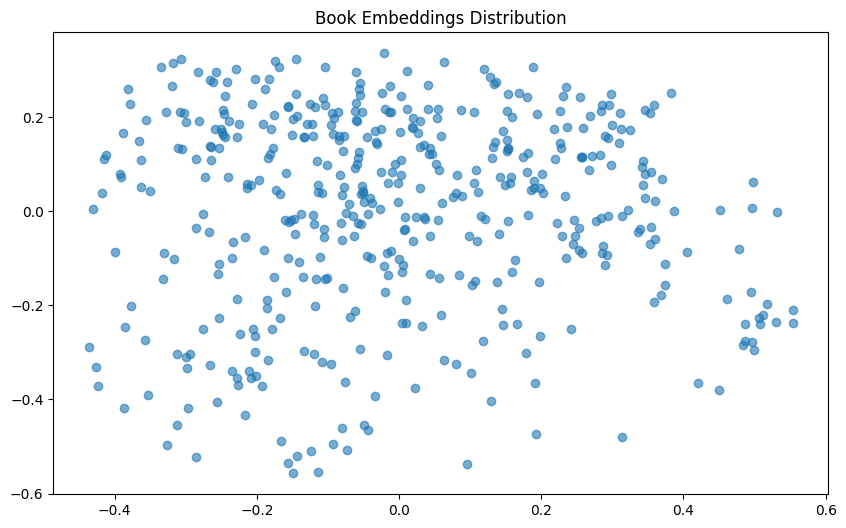

In [45]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced = pca.fit_transform(book_embeddings)

plt.figure(figsize=(10,6))
plt.scatter(reduced[:,0], reduced[:,1], alpha=0.6)
plt.title("Book Embeddings Distribution")
plt.show()


**Reasoning**:
Define the `recommend_by_theme` function to filter the DataFrame based on the provided theme and return the top k results with relevant columns.



In [46]:
!pip install rapidfuzz --quiet
import pandas as pd
from rapidfuzz import process

def recommend_by_theme(theme_query: str, k: int = 10) -> pd.DataFrame:
    """
    Recommends books based on a given theme query, using fuzzy matching for flexible input.
    """
    if 'aw' not in globals() or not isinstance(aw, pd.DataFrame) or aw.empty or 'themes' not in aw.columns:
        print("Error: Canonicalized DataFrame 'aw' with 'themes' column not found or is empty.")
        return pd.DataFrame()

    # Normalize themes into a flat set of lowercase strings
    all_themes = set()
    for entry in aw['themes'].dropna():
        if isinstance(entry, list):
            all_themes.update([str(t).lower() for t in entry])
        else:
            all_themes.add(str(entry).lower())

    # Fuzzy match the input against available themes
    best_match, score, _ = process.extractOne(theme_query.lower(), list(all_themes), score_cutoff=60)

    if best_match:
        # Filter rows where the matched theme is present
        def has_theme(theme_list):
            if isinstance(theme_list, list):
                return any(str(t).lower() == best_match for t in theme_list)
            return str(theme_list).lower() == best_match

        filtered_df = aw[aw['themes'].apply(has_theme)]

        if filtered_df.empty:
            print(f"No books found for the theme: '{best_match}'")
            return pd.DataFrame()

        return filtered_df[['title', 'author', 'themes', 'image_url']].head(k)

    else:
        print(f"No close matches found for '{theme_query}'. Available themes include: {list(all_themes)[:10]} ...")
        return pd.DataFrame()

**Reasoning**:
The `recommend_by_theme` function has been defined. Now, test the function with an example theme query to ensure it works as expected and displays the results.



In [47]:
# Test the recommend_by_theme function
example_theme = "love"
recommended_books_by_theme = recommend_by_theme(example_theme, k=5)

print(f"\nRecommended books for theme '{example_theme}':")
display(recommended_books_by_theme)


Recommended books for theme 'love':


,title,author,themes,image_url
112,"Allan deSouza, a decade of photoworks, 1998-2008",Allan DeSouza,"[Parent-child relationships, Hard work, Love a...",NaN
114,AlterNatives,Allan DeSouza,"[Greed, Love and heartbreak, Poverty]",http://books.google.com/books/content?id=aotLA...
115,Crossing black waters,Allan DeSouza,"[Love and heartbreak, Greed, Fate and free will]",http://books.google.com/books/content?id=zc83A...
139,Eagles at war,Ben Kane,"[Colonialism and resistance, Love and heartbre...",https://covers.openlibrary.org/b/id/10195404-L...
140,Eagles in the storm,Ben Kane,"[Parent-child relationships, Love and heartbre...",https://covers.openlibrary.org/b/id/10159176-L...


## Create a book visualization function

### Subtask:
Develop a function that takes a list of book items and displays their covers and relevant information in a grid format.


**Reasoning**:
Define the `display_books_grid` function to visualize book covers and information in a grid format, handling image loading and display.



In [48]:
import math
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

def display_books_grid(df, k=10, cols=5):
    """
    Display up to k books from the DataFrame in a grid with covers and titles.
    Expects df to have at least 'title' and optionally 'image_url' columns.
    """
    # Select the books to display
    books_to_display = df.head(k)
    num_books = len(books_to_display)

    # Compute grid size
    rows = math.ceil(num_books / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 4))

    # Normalize axes into a flat list
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for i, (idx, book) in enumerate(books_to_display.iterrows()):
        ax = axes[i]
        ax.axis("off")

        # Try to display cover image if available
        img = None
        if "image_url" in book and pd.notnull(book["image_url"]):
            try:
                import requests
                from PIL import Image
                from io import BytesIO
                response = requests.get(book["image_url"], timeout=5)
                img = Image.open(BytesIO(response.content))
                ax.imshow(img)
            except Exception:
                ax.text(0.5, 0.5, "No Image", ha="center", va="center")

        # Add title text below image
        ax.set_title(str(book.get("title", "Untitled")), fontsize=9)

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

print("`display_books_grid` function defined.")

`display_books_grid` function defined.


**Reasoning**:
Test the `display_books_grid` function with the previously generated recommended books DataFrame to visualize the results.



Displaying recommended books:


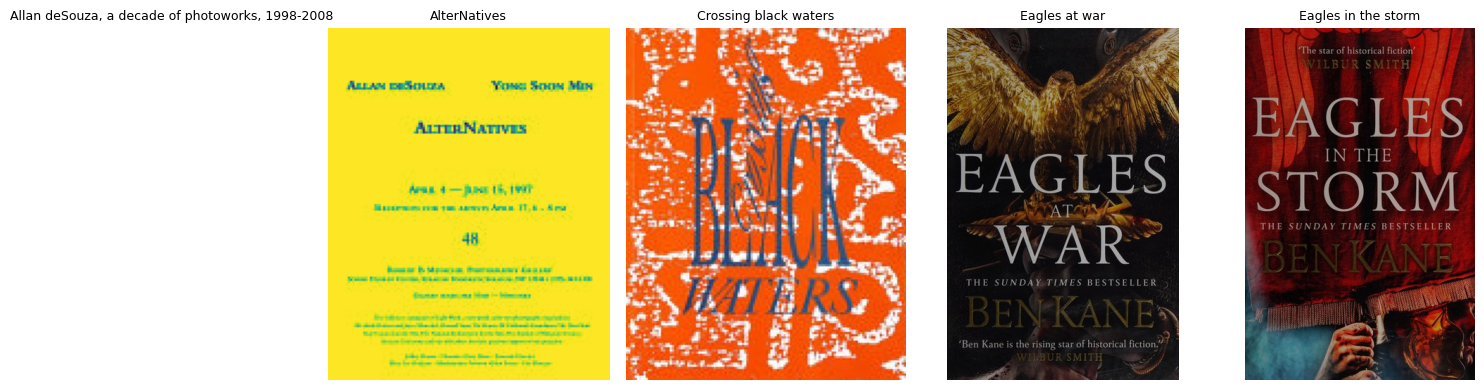

In [49]:
# Test the display function with the recommended books DataFrame
if 'recommended_books_by_theme' in globals() and not recommended_books_by_theme.empty:
    print("Displaying recommended books:")
    display_books_grid(recommended_books_by_theme, k=10)
else:
    print("No recommended books DataFrame found or it is empty. Cannot display.")

## Connect theme recommendations to visualization

### Subtask:
Use the theme-based recommendation function to get a list of books and then pass that list to the visualization function.


**Reasoning**:
Call the theme-based recommendation function and then the visualization function with the result.



Displaying recommended books for theme: 'religion'


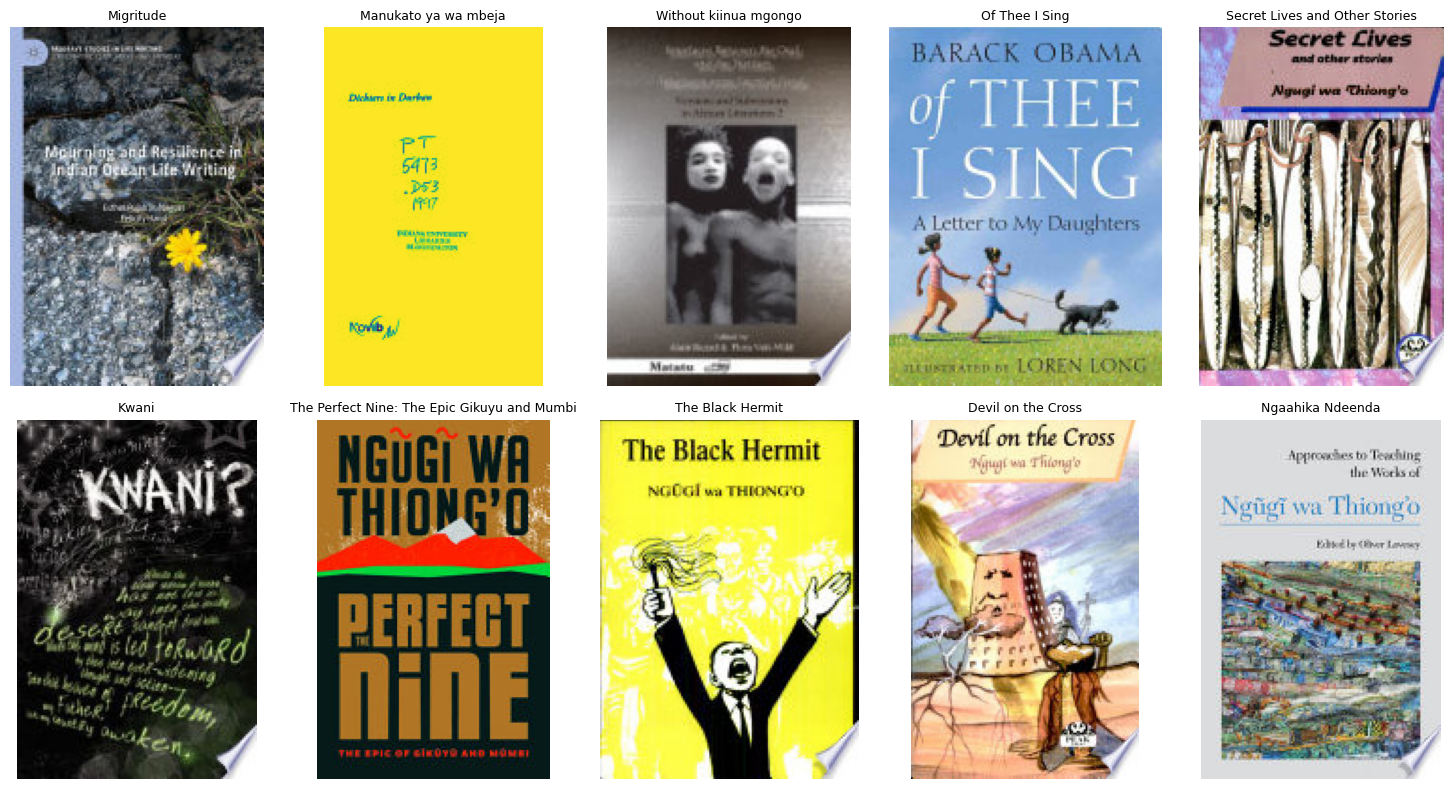

In [50]:
from IPython.display import display
# Call the recommend_by_theme function
selected_theme = "religion"
recommended_books_for_theme = recommend_by_theme(selected_theme, k=10)

# Call the display_books_grid function with the recommended books
if not recommended_books_for_theme.empty:
    print(f"Displaying recommended books for theme: '{selected_theme}'")
    display_books_grid(recommended_books_for_theme, k=10)
else:
    print(f"No books found for theme: '{selected_theme}' to display.")